In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.compose import ColumnTransformer
import statsmodels.api as sma
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn import tree
from scipy.stats import randint
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

In [2]:
df1=pd.read_csv("df_trim.csv")
df1.head()

,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales,product_class_id,brand_name,...,houseowner,num_cars_owned,fullname,the_date,the_day,the_year,the_month,day_of_month,day_since_epoch,promotion_period
0,451,677,7366,207,3,7.12,2.2784,4,55,Red Wing,...,Y,4,Ann Smith,11/7/1997,Friday,1997,11,7,34279,4
1,1293,677,7366,207,3,5.76,1.7856,4,14,Booker,...,Y,4,Ann Smith,11/7/1997,Friday,1997,11,7,34279,4
2,738,677,7366,207,3,5.55,2.0535,3,39,Consolidated,...,Y,4,Ann Smith,11/7/1997,Friday,1997,11,7,34279,4
3,1426,677,8947,207,3,7.48,2.2440,2,61,Hermanos,...,Y,2,Robert Bell,11/7/1997,Friday,1997,11,7,34279,4
4,338,677,8947,207,3,2.28,1.0488,4,58,Better,...,Y,2,Robert Bell,11/7/1997,Friday,1997,11,7,34279,4


In [3]:
#Impute null values with median for specified columns
columns_to_impute = ['store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft']
imputer = SimpleImputer(strategy='median')
df1[columns_to_impute] = imputer.fit_transform(df1[columns_to_impute])

In [4]:
# Check for remaining null values
df_null = df1.isnull().sum()
df_null

product_id          0
time_id             0
customer_id         0
promotion_id        0
store_id            0
                   ..
the_year            0
the_month           0
day_of_month        0
day_since_epoch     0
promotion_period    0
Length: 94, dtype: int64

In [5]:
# Remove specified columns
columns_to_remove = ["lname", "fname", "mi", "address1", "address2"]
df1 = df1.drop(columns=columns_to_remove)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70751 entries, 0 to 70750
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             70751 non-null  int64  
 1   time_id                70751 non-null  int64  
 2   customer_id            70751 non-null  int64  
 3   promotion_id           70751 non-null  int64  
 4   store_id               70751 non-null  int64  
 5   store_sales            70751 non-null  float64
 6   store_cost             70751 non-null  float64
 7   unit_sales             70751 non-null  int64  
 8   product_class_id       70751 non-null  int64  
 9   brand_name             70751 non-null  object 
 10  product_name           70751 non-null  object 
 11  SKU                    70751 non-null  int64  
 12  SRP                    70751 non-null  float64
 13  gross_weight           70751 non-null  float64
 14  net_weight             70751 non-null  float64
 15  re

# trying model with 56 columns where id columns, date columns are removed.

In [38]:
df_old=df1[['store_sales', 'store_cost', 'unit_sales','brand_name', 'product_name','SRP', 'gross_weight',
       'net_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth',
       'subcategory', 'category', 'department', 'family','promotion_name', 'media_type', 'cost','sales_city',
       'sales_state_province', 'sales_district', 'sales_region',
       'sales_country','store_type', 'store_name','store_city', 'store_state','store_country', 'store_manager','store_sqft',
       'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist','city',
       'state_province','country','marital_status', 'yearly_income',
       'gender', 'total_children', 'num_children_at_home', 'education','member_card', 'occupation', 'houseowner',
       'num_cars_owned','promotion_period']]

In [39]:
def column_index(df, query_cols):
  '''
  returns the indices of the query_cols
  '''
  cols = df.columns.values
  sidx = np.argsort(cols)
  return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]




In [40]:
df_old_s=df_old.copy()

In [41]:
ss=StandardScaler()
df_old_num=df_old_s.select_dtypes(include=np.number)
df_old_num=pd.DataFrame(data=ss.fit_transform(df_old_num),columns=df_old_num.columns)

In [42]:
df_old_num

,store_sales,store_cost,unit_sales,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,cases_per_pallet,...,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_children_at_home,num_cars_owned,promotion_period
0,0.167248,-0.232756,1.091694,-0.360711,-0.087623,-0.105682,0.888761,-0.735239,0.599209,0.585274,...,2.677889,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.363531,0.900064,1.622032,0.160704
1,-0.224240,-0.571062,1.091694,-0.724667,-1.201908,-1.397560,-1.125162,1.360101,0.306785,-1.314330,...,2.677889,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.363531,0.900064,1.622032,0.160704
2,-0.284690,-0.387149,-0.107158,-0.285779,-1.446401,-1.640988,0.888761,-0.735239,1.476480,-0.554489,...,2.677889,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.363531,0.900064,1.622032,0.160704
3,0.270877,-0.256371,-1.306011,1.737389,-0.152533,0.065145,-1.125162,1.360101,0.209310,1.345116,...,2.677889,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.363531,-0.635015,-0.185232,0.160704
4,-1.225988,-1.076874,1.091694,-1.655967,0.669657,0.641685,0.888761,-0.735239,-1.252808,0.205353,...,2.677889,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.363531,-0.635015,-0.185232,0.160704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,0.328449,0.628387,-0.107158,0.474247,-0.715085,-0.703576,-1.125162,1.360101,-0.667961,1.345116,...,-0.742862,0.765058,-0.658527,-1.249857,-1.096743,0.836983,0.976167,-0.635015,0.718400,-0.092165
70747,-1.061909,-1.190352,2.290547,-1.655967,-0.974724,-0.959816,0.888761,-0.735239,0.501734,0.965195,...,-0.742862,0.765058,-0.658527,-1.249857,-1.096743,0.836983,0.976167,-0.635015,0.718400,-0.092165
70748,-0.647392,-0.795547,-0.107158,-0.735372,-0.779994,-0.983305,-1.125162,-0.735239,-1.350283,-0.934409,...,-0.742862,0.765058,-0.658527,-1.249857,-1.096743,0.836983,-1.033380,-0.635015,-0.185232,-0.092165
70749,-0.391198,-0.374449,-1.306011,0.506361,-0.873032,-0.859455,0.888761,1.360101,0.111836,0.205353,...,-0.742862,0.765058,-0.658527,-1.249857,-1.096743,0.836983,-1.033380,-0.635015,-0.185232,-0.092165


In [43]:
df_old_cat=df_old_s.select_dtypes(exclude=np.number)

In [44]:
df_old_scaled=pd.concat([df_old_num,df_old_cat],axis=1)

In [45]:
df_old_scaled=pd.get_dummies(df_old_scaled,drop_first=True)

In [46]:
df_old_scaled

,store_sales,store_cost,unit_sales,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,cases_per_pallet,...,education_Partial College,education_Partial High School,member_card_Golden,member_card_Normal,member_card_Silver,occupation_Management,occupation_Manual,occupation_Professional,occupation_Skilled Manual,houseowner_Y
0,0.167248,-0.232756,1.091694,-0.360711,-0.087623,-0.105682,0.888761,-0.735239,0.599209,0.585274,...,0,0,0,0,0,0,0,0,1,1
1,-0.224240,-0.571062,1.091694,-0.724667,-1.201908,-1.397560,-1.125162,1.360101,0.306785,-1.314330,...,0,0,0,0,0,0,0,0,1,1
2,-0.284690,-0.387149,-0.107158,-0.285779,-1.446401,-1.640988,0.888761,-0.735239,1.476480,-0.554489,...,0,0,0,0,0,0,0,0,1,1
3,0.270877,-0.256371,-1.306011,1.737389,-0.152533,0.065145,-1.125162,1.360101,0.209310,1.345116,...,0,0,0,1,0,0,0,0,1,1
4,-1.225988,-1.076874,1.091694,-1.655967,0.669657,0.641685,0.888761,-0.735239,-1.252808,0.205353,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,0.328449,0.628387,-0.107158,0.474247,-0.715085,-0.703576,-1.125162,1.360101,-0.667961,1.345116,...,0,0,0,0,1,1,0,0,0,1
70747,-1.061909,-1.190352,2.290547,-1.655967,-0.974724,-0.959816,0.888761,-0.735239,0.501734,0.965195,...,0,0,0,0,1,1,0,0,0,1
70748,-0.647392,-0.795547,-0.107158,-0.735372,-0.779994,-0.983305,-1.125162,-0.735239,-1.350283,-0.934409,...,0,0,1,0,0,0,0,1,0,1
70749,-0.391198,-0.374449,-1.306011,0.506361,-0.873032,-0.859455,0.888761,1.360101,0.111836,0.205353,...,0,0,1,0,0,0,0,1,0,1


In [47]:
df_old_scaled.shape

(70751, 2203)

* too many columns for us to ascertain some meaning.

# keeping 43 columns where names are removed

In [48]:
#Taking columns that are needed
df_new=df1[['recyclable_package', 'low_fat', 'department', 'family', 'promotion_name', 'media_type', 'sales_district', 'sales_region', 'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'state_province', 'country', 'marital_status', 'yearly_income', 'gender', 'education','member_card', 'occupation', 'houseowner','store_sales', 'store_cost', 'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'units_per_case', 'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth', 'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'total_children', 'num_children_at_home', 'num_cars_owned', 'promotion_period']]

In [50]:
le=LabelEncoder()
df_new_num=df_new.select_dtypes(include=np.number)
df_new_cat=df_new.select_dtypes(exclude=np.number)

In [51]:
# Scale numerical columns
ss = StandardScaler()
df_new_num_scaled = pd.DataFrame(data=ss.fit_transform(df_new_num), columns=df_new_num.columns)

In [65]:
for col in df_new_cat.columns:
    df_new_cat[col] = le.fit_transform(df_new_cat[col])

In [66]:
df_new_cat

,department,family,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,14,2,38,1,2,5,4,9,2,0,4,0,2,0,4,1
1,9,1,38,1,2,5,4,9,2,0,4,0,2,0,4,1
2,13,2,38,1,2,5,4,9,2,0,4,0,2,0,4,1
3,17,1,38,1,2,5,4,9,2,1,5,1,2,2,4,1
4,5,1,38,1,2,5,4,9,2,1,5,1,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,1,35,5,18,0,2,0,0,1,1,1,2,3,1,1
70747,17,1,35,5,18,0,2,0,0,1,1,1,2,3,1,1
70748,14,2,35,5,18,0,2,0,0,1,7,1,0,1,3,1
70749,17,1,35,5,18,0,2,0,0,1,7,1,0,1,3,1


In [67]:
df_new_num_scaled

,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,store_sales,store_cost,unit_sales,...,shelf_depth,cost,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,total_children,num_children_at_home,num_cars_owned,promotion_period
0,0.888761,-0.735239,-1.307090,-0.658527,0.800092,0.911790,-1.194767,0.167248,-0.232756,1.091694,...,1.241403,1.008678,2.229818,1.443314,2.678215,2.677889,-0.363531,0.900064,1.622032,0.160704
1,-1.125162,1.360101,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.224240,-0.571062,1.091694,...,-0.346099,1.008678,2.229818,1.443314,2.678215,2.677889,-0.363531,0.900064,1.622032,0.160704
2,0.888761,-0.735239,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-0.284690,-0.387149,-0.107158,...,-1.386001,1.008678,2.229818,1.443314,2.678215,2.677889,-0.363531,0.900064,1.622032,0.160704
3,-1.125162,1.360101,-1.307090,-0.658527,0.800092,0.911790,-1.194767,0.270877,-0.256371,-1.306011,...,-0.453121,1.008678,2.229818,1.443314,2.678215,2.677889,-0.363531,-0.635015,-0.185232,0.160704
4,0.888761,-0.735239,-1.307090,-0.658527,0.800092,0.911790,-1.194767,-1.225988,-1.076874,1.091694,...,-0.706408,1.008678,2.229818,1.443314,2.678215,2.677889,-0.363531,-0.635015,-0.185232,0.160704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,-1.125162,1.360101,0.765058,-0.658527,-1.249857,-1.096743,0.836983,0.328449,0.628387,-0.107158,...,1.384100,1.027528,1.234696,2.276411,-0.742417,-0.742862,0.976167,-0.635015,0.718400,-0.092165
70747,0.888761,-0.735239,0.765058,-0.658527,-1.249857,-1.096743,0.836983,-1.061909,-1.190352,2.290547,...,-1.569723,1.027528,1.234696,2.276411,-0.742417,-0.742862,0.976167,-0.635015,0.718400,-0.092165
70748,-1.125162,-0.735239,0.765058,-0.658527,-1.249857,-1.096743,0.836983,-0.647392,-0.795547,-0.107158,...,1.455448,1.027528,1.234696,2.276411,-0.742417,-0.742862,-1.033380,-0.635015,-0.185232,-0.092165
70749,0.888761,1.360101,0.765058,-0.658527,-1.249857,-1.096743,0.836983,-0.391198,-0.374449,-1.306011,...,0.563593,1.027528,1.234696,2.276411,-0.742417,-0.742862,-1.033380,-0.635015,-0.185232,-0.092165


In [68]:
df_new_cluster=pd.concat([df_new_num_scaled,df_new_cat],axis=1)

In [69]:
df_new_cluster.columns

Index(['recyclable_package', 'low_fat', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist', 'store_sales', 'store_cost',
       'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'units_per_case',
       'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth',
       'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft',
       'total_children', 'num_children_at_home', 'num_cars_owned',
       'promotion_period', 'department', 'family', 'promotion_name',
       'media_type', 'sales_district', 'sales_region', 'store_type',
       'state_province', 'country', 'marital_status', 'yearly_income',
       'gender', 'education', 'member_card', 'occupation', 'houseowner'],
      dtype='object')

In [70]:
df_new_cluster.head()

,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,store_sales,store_cost,unit_sales,...,store_type,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,0.888761,-0.735239,-1.30709,-0.658527,0.800092,0.91179,-1.194767,0.167248,-0.232756,1.091694,...,4,9,2,0,4,0,2,0,4,1
1,-1.125162,1.360101,-1.30709,-0.658527,0.800092,0.91179,-1.194767,-0.224240,-0.571062,1.091694,...,4,9,2,0,4,0,2,0,4,1
2,0.888761,-0.735239,-1.30709,-0.658527,0.800092,0.91179,-1.194767,-0.284690,-0.387149,-0.107158,...,4,9,2,0,4,0,2,0,4,1
3,-1.125162,1.360101,-1.30709,-0.658527,0.800092,0.91179,-1.194767,0.270877,-0.256371,-1.306011,...,4,9,2,1,5,1,2,2,4,1
4,0.888761,-0.735239,-1.30709,-0.658527,0.800092,0.91179,-1.194767,-1.225988,-1.076874,1.091694,...,4,9,2,1,5,1,2,2,4,1


In [71]:
num_col=['store_sales', 'store_cost', 'unit_sales','SRP', 'gross_weight',
       'net_weight', 'units_per_case',
       'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth',
       'cost','store_sqft','grocery_sqft', 'frozen_sqft', 'meat_sqft', 
       'total_children', 'num_children_at_home', 'num_cars_owned','day_since_epoch', 'promotion_period']

In [72]:
num_col_index=[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

In [73]:
cat_col_index=[0,1,2,3,4,5,6,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]

def column_index(df, query_cols):
  '''
  returns the indices of the query_cols
  '''
  cols = df.columns.values
  sidx = np.argsort(cols)
  return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

cat_cols = df_new.select_dtypes(include='object')
categorical_indices = column_index(df_new_cluster, cat_cols.columns)
categorical = list(categorical_indices)

In [74]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Evaluate silhouette scores for different cluster numbers
for n_clusters in range(2, 6):
    kproto = KPrototypes(n_clusters=n_clusters, init='Cao', verbose=0, n_init=1)
    clusters = kproto.fit_predict(df_new_cluster, categorical=cat_col_index)
    silhouette_avg = silhouette_score(df_new_scaled.values, clusters)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")


Number of clusters: 2, Silhouette Score: 0.026243342690114153
Number of clusters: 3, Silhouette Score: 0.015319871359456652
Number of clusters: 4, Silhouette Score: 0.013688521269752747
Number of clusters: 5, Silhouette Score: 0.01454341086379571


# keeping 16 columns(15 columns) excluding cost. so we attempt Kprototype clustering for 15 columns which gave us our best model for prediction of cost.

In [7]:
df_cluster=df1[['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'video_store', 'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'SRP', 'net_weight', 'store_sqft', 
'promotion_period']]

In [8]:
df_cluster

,department,promotion_name,media_type,sales_district,store_type,video_store,yearly_income,member_card,occupation,store_cost,unit_sales,SRP,net_weight,store_sqft,promotion_period
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$30K - $50K,Bronze,Skilled Manual,2.2784,4,1.78,11.30,39696.0,4
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$30K - $50K,Bronze,Skilled Manual,1.7856,4,1.44,5.25,39696.0,4
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$30K - $50K,Bronze,Skilled Manual,2.0535,3,1.85,4.11,39696.0,4
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$50K - $70K,Normal,Skilled Manual,2.2440,2,3.74,12.10,39696.0,4
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$50K - $70K,Normal,Skilled Manual,1.0488,4,0.57,14.80,39696.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$110K - $130K,Silver,Management,3.5328,3,2.56,8.50,34452.0,3
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$110K - $130K,Silver,Management,0.8835,5,0.57,7.30,34452.0,3
70748,Household,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$90K - $110K,Golden,Professional,1.4586,3,1.43,7.19,34452.0,3
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$90K - $110K,Golden,Professional,2.0720,2,2.59,7.77,34452.0,3


In [9]:
le=LabelEncoder()
df_cluster_num=df_cluster.select_dtypes(include=np.number)
df_cluster_cat=df_cluster.select_dtypes(exclude=np.number)

In [10]:
df_cluster_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70748,Household,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional


In [11]:
df_cluster_num

,video_store,store_cost,unit_sales,SRP,net_weight,store_sqft,promotion_period
0,0,2.2784,4,1.78,11.30,39696.0,4
1,0,1.7856,4,1.44,5.25,39696.0,4
2,0,2.0535,3,1.85,4.11,39696.0,4
3,0,2.2440,2,3.74,12.10,39696.0,4
4,0,1.0488,4,0.57,14.80,39696.0,4
...,...,...,...,...,...,...,...
70746,0,3.5328,3,2.56,8.50,34452.0,3
70747,0,0.8835,5,0.57,7.30,34452.0,3
70748,0,1.4586,3,1.43,7.19,34452.0,3
70749,0,2.0720,2,2.59,7.77,34452.0,3


In [12]:
for col in df_cluster_cat.columns:
    df_cluster_cat[col] = le.fit_transform(df_cluster_cat[col])

In [13]:
df_cluster_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,14,38,1,2,4,4,0,4
1,9,38,1,2,4,4,0,4
2,13,38,1,2,4,4,0,4
3,17,38,1,2,4,5,2,4
4,5,38,1,2,4,5,2,4
...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1
70747,17,35,5,18,2,1,3,1
70748,14,35,5,18,2,7,1,3
70749,17,35,5,18,2,7,1,3


In [14]:
df_cluster_num.columns

Index(['video_store', 'store_cost', 'unit_sales', 'SRP', 'net_weight',
       'store_sqft', 'promotion_period'],
      dtype='object')

In [15]:
df_cluster_num_new=df_cluster[['store_cost', 'unit_sales', 'SRP', 'net_weight',
       'store_sqft', 'promotion_period']]

In [16]:
ss = StandardScaler()
df_cluster_num_scaled = pd.DataFrame(data=ss.fit_transform(df_cluster_num_new), columns=df_cluster_num_new.columns)

In [17]:
df_cluster_num_scaled

,store_cost,unit_sales,SRP,net_weight,store_sqft,promotion_period
0,-0.232756,1.091694,-0.360711,-0.105682,2.229818,0.160704
1,-0.571062,1.091694,-0.724667,-1.397560,2.229818,0.160704
2,-0.387149,-0.107158,-0.285779,-1.640988,2.229818,0.160704
3,-0.256371,-1.306011,1.737389,0.065145,2.229818,0.160704
4,-1.076874,1.091694,-1.655967,0.641685,2.229818,0.160704
...,...,...,...,...,...,...
70746,0.628387,-0.107158,0.474247,-0.703576,1.234696,-0.092165
70747,-1.190352,2.290547,-1.655967,-0.959816,1.234696,-0.092165
70748,-0.795547,-0.107158,-0.735372,-0.983305,1.234696,-0.092165
70749,-0.374449,-1.306011,0.506361,-0.859455,1.234696,-0.092165


In [18]:
df_cluster_num=pd.concat([df_cluster_num["video_store"],df_cluster_num_scaled],axis=1)

In [19]:
df_cluster_num

,video_store,store_cost,unit_sales,SRP,net_weight,store_sqft,promotion_period
0,0,-0.232756,1.091694,-0.360711,-0.105682,2.229818,0.160704
1,0,-0.571062,1.091694,-0.724667,-1.397560,2.229818,0.160704
2,0,-0.387149,-0.107158,-0.285779,-1.640988,2.229818,0.160704
3,0,-0.256371,-1.306011,1.737389,0.065145,2.229818,0.160704
4,0,-1.076874,1.091694,-1.655967,0.641685,2.229818,0.160704
...,...,...,...,...,...,...,...
70746,0,0.628387,-0.107158,0.474247,-0.703576,1.234696,-0.092165
70747,0,-1.190352,2.290547,-1.655967,-0.959816,1.234696,-0.092165
70748,0,-0.795547,-0.107158,-0.735372,-0.983305,1.234696,-0.092165
70749,0,-0.374449,-1.306011,0.506361,-0.859455,1.234696,-0.092165


In [20]:
df_cluster_final=pd.concat([df_cluster_cat,df_cluster_num],axis=1)

In [21]:
df_cluster_final

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation,video_store,store_cost,unit_sales,SRP,net_weight,store_sqft,promotion_period
0,14,38,1,2,4,4,0,4,0,-0.232756,1.091694,-0.360711,-0.105682,2.229818,0.160704
1,9,38,1,2,4,4,0,4,0,-0.571062,1.091694,-0.724667,-1.397560,2.229818,0.160704
2,13,38,1,2,4,4,0,4,0,-0.387149,-0.107158,-0.285779,-1.640988,2.229818,0.160704
3,17,38,1,2,4,5,2,4,0,-0.256371,-1.306011,1.737389,0.065145,2.229818,0.160704
4,5,38,1,2,4,5,2,4,0,-1.076874,1.091694,-1.655967,0.641685,2.229818,0.160704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1,0,0.628387,-0.107158,0.474247,-0.703576,1.234696,-0.092165
70747,17,35,5,18,2,1,3,1,0,-1.190352,2.290547,-1.655967,-0.959816,1.234696,-0.092165
70748,14,35,5,18,2,7,1,3,0,-0.795547,-0.107158,-0.735372,-0.983305,1.234696,-0.092165
70749,17,35,5,18,2,7,1,3,0,-0.374449,-1.306011,0.506361,-0.859455,1.234696,-0.092165


In [24]:
df_cluster_final.columns

Index(['department', 'promotion_name', 'media_type', 'sales_district',
       'store_type', 'yearly_income', 'member_card', 'occupation',
       'video_store', 'store_cost', 'unit_sales', 'SRP', 'net_weight',
       'store_sqft', 'promotion_period'],
      dtype='object')

In [25]:
cat_col_index=[0,1,2,3,4,5,6,7,8]

In [27]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Evaluate silhouette scores for different cluster numbers
for n_clusters in range(2, 8):
    kproto = KPrototypes(n_clusters=n_clusters, init='Cao', verbose=0, n_init=1,random_state=42,n_jobs=-1)
    clusters = kproto.fit_predict(df_cluster_final, categorical=cat_col_index)
    silhouette_avg = silhouette_score(df_cluster_num.values, clusters)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

Number of clusters: 2, Silhouette Score: 0.20910301513616183
Number of clusters: 3, Silhouette Score: 0.158457325758795
Number of clusters: 4, Silhouette Score: 0.1634887394379146
Number of clusters: 5, Silhouette Score: 0.18546257964745613
Number of clusters: 6, Silhouette Score: 0.1760828279190782
Number of clusters: 7, Silhouette Score: 0.17275514986743756


* highest silhouette score is for no of clusters=2.

In [28]:
kproto = KPrototypes(n_clusters=2, init='Cao', verbose=0, n_init=1,random_state=42,n_jobs=-1)
clusters = kproto.fit_predict(df_cluster_final, categorical=cat_col_index)

In [29]:
cluster_centers=kproto.cluster_centroids_

In [32]:
centroids_df = pd.DataFrame(cluster_centers, columns=df_cluster.columns)

In [33]:
centroids_df

,department,promotion_name,media_type,sales_district,store_type,video_store,yearly_income,member_card,occupation,store_cost,unit_sales,SRP,net_weight,store_sqft,promotion_period
0,0.928066,0.404948,0.851781,0.072068,0.027492,-0.005063,17.0,29.0,3.0,6.0,4.0,4.0,0.0,3.0,0.0
1,-0.684528,-0.298684,-0.628261,-0.053157,-0.020278,0.003734,17.0,43.0,3.0,6.0,4.0,4.0,0.0,3.0,0.0


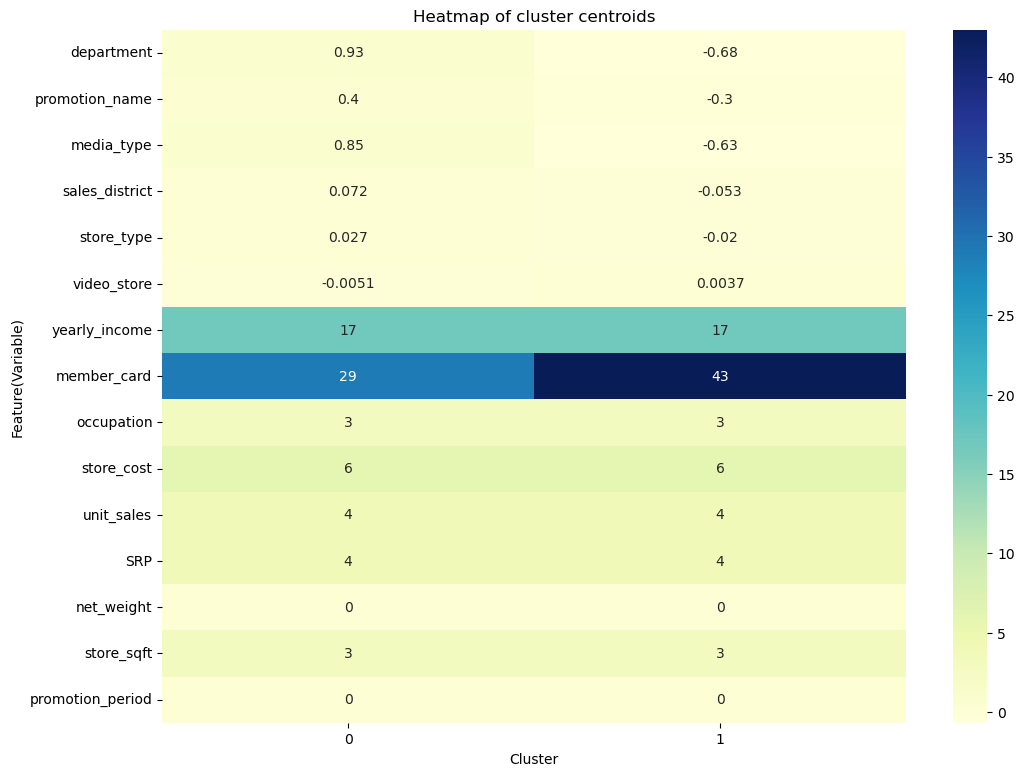

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
sns.heatmap(centroids_df.transpose(),cmap="YlGnBu",annot=True)
plt.title("Heatmap of cluster centroids")
plt.xlabel("Cluster")
plt.ylabel("Feature(Variable)")
plt.show()

* Not able to distinguish clusters based on numerical column. categorical columns are label encoded so the difference can't be interpreted.

In [35]:
df_cluster["cluster"]=clusters

C:\Users\hp\AppData\Local\Temp\ipykernel_20736\739576732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["cluster"]=clusters


In [36]:
df_cluster["cluster"].value_counts()

1    40718
0    30033
Name: cluster, dtype: int64

In [40]:
df_cluster.dtypes

department           object
promotion_name       object
media_type           object
sales_district       object
store_type           object
video_store           int64
yearly_income        object
member_card          object
occupation           object
store_cost          float64
unit_sales            int64
SRP                 float64
net_weight          float64
store_sqft          float64
promotion_period      int64
cluster              uint16
dtype: object

In [41]:
df_cluster["video_store"]=df_cluster["video_store"].astype("object")

C:\Users\hp\AppData\Local\Temp\ipykernel_20736\1192652861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["video_store"]=df_cluster["video_store"].astype("object")


In [42]:
df_cluster[df_cluster["cluster"]==0].describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
department,30033,22,Produce,4417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
promotion_name,30033,49,Price Winners,1427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
media_type,30033,13,"Daily Paper, Radio",3262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales_district,30033,21,Los Angeles,3457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_type,30033,5,Supermarket,13442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_store,30033.0,2.0,0.0,20769.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearly_income,30033,8,$30K - $50K,9821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_card,30033,4,Bronze,16837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,30033,5,Professional,9853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_cost,30033.0,NaN,NaN,NaN,3.969332,1.11965,1.791,3.1416,3.6942,4.5864,9.7265


In [43]:
df_cluster[df_cluster["cluster"]==1].describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
department,40718,22,Produce,5587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
promotion_name,40718,49,Two Day Sale,1772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
media_type,40718,13,"Daily Paper, Radio",4477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales_district,40718,21,Los Angeles,4654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_type,40718,5,Supermarket,17254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_store,40718.0,2.0,0.0,28581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearly_income,40718,8,$30K - $50K,12966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_card,40718,4,Bronze,22737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,40718,5,Professional,13494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_cost,40718.0,NaN,NaN,NaN,1.620318,0.64813,0.1632,1.0881,1.632,2.1456,3.2112


In [45]:
df_cluster_num=df_cluster.select_dtypes(include=np.number)
df_cluster_cat=df_cluster.select_dtypes(exclude=np.number)

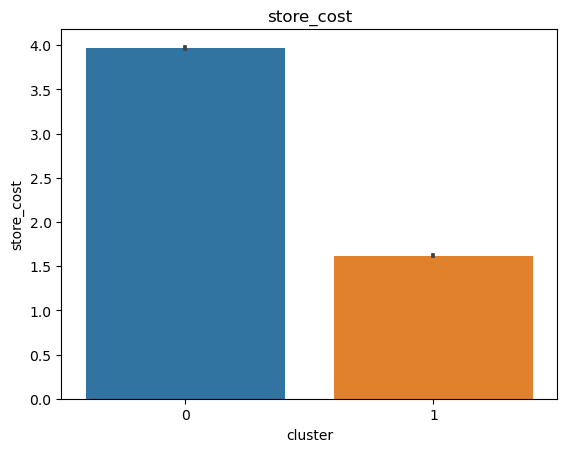

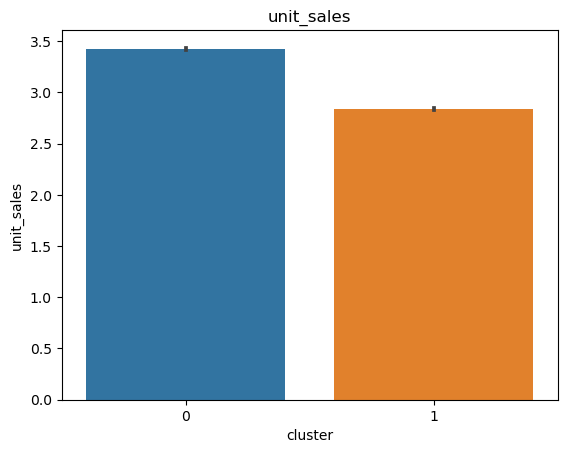

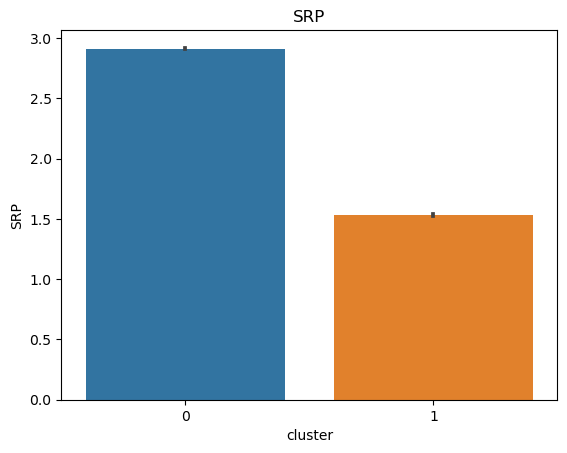

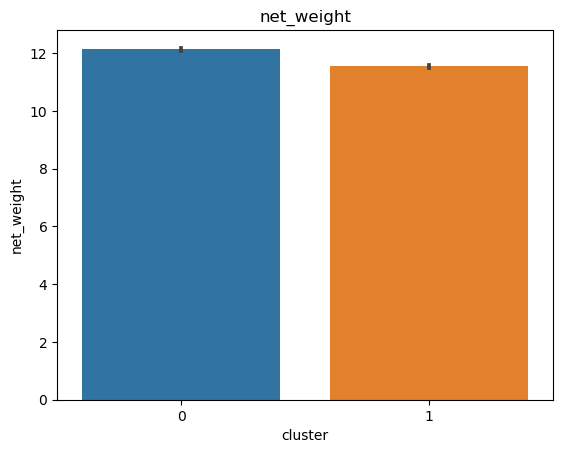

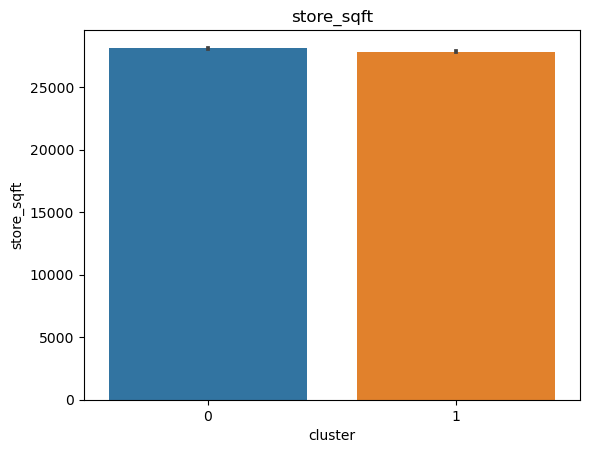

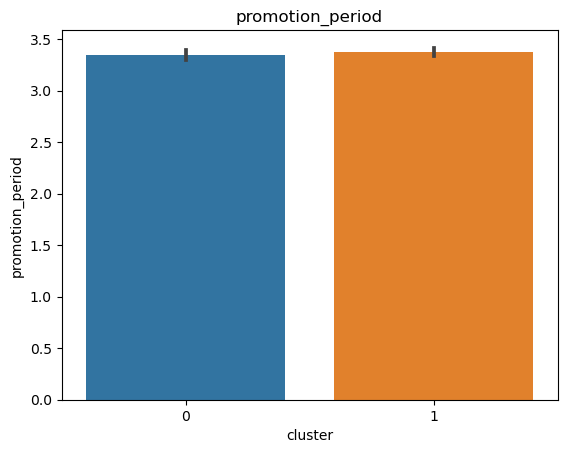

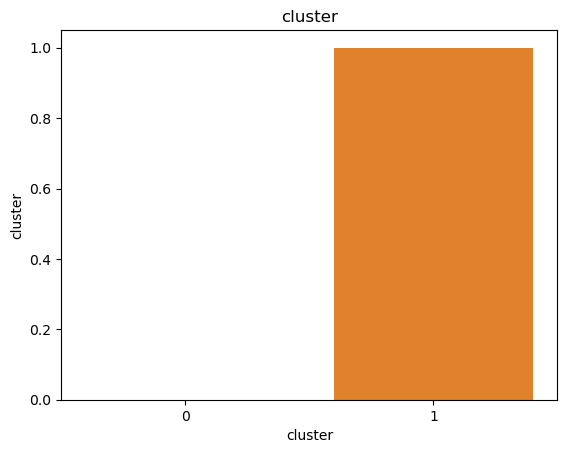

In [49]:
for i in df_cluster_num.columns:
    sns.barplot(y=df_cluster_num[i],x=df_cluster["cluster"])
    plt.title(i)
    plt.show()

In [ ]:
# cluster 0.
# on an average, customers buy product of unit_cost of $4(higher than 1).
# on an average, customers buy more than 3 units (higher than 1).
# on an average, customers buy product of SRP of near $3 (higher than 1).
# on an average, customers buy product of net_weight of more than 12 ounces (higher than 1).
# on an average, customers visit store of around 28000 sq.ft (slightly higher than 1).
# on an average, customers visit store where promotion has been going on for around 3.3 days (slightly lower than 1).

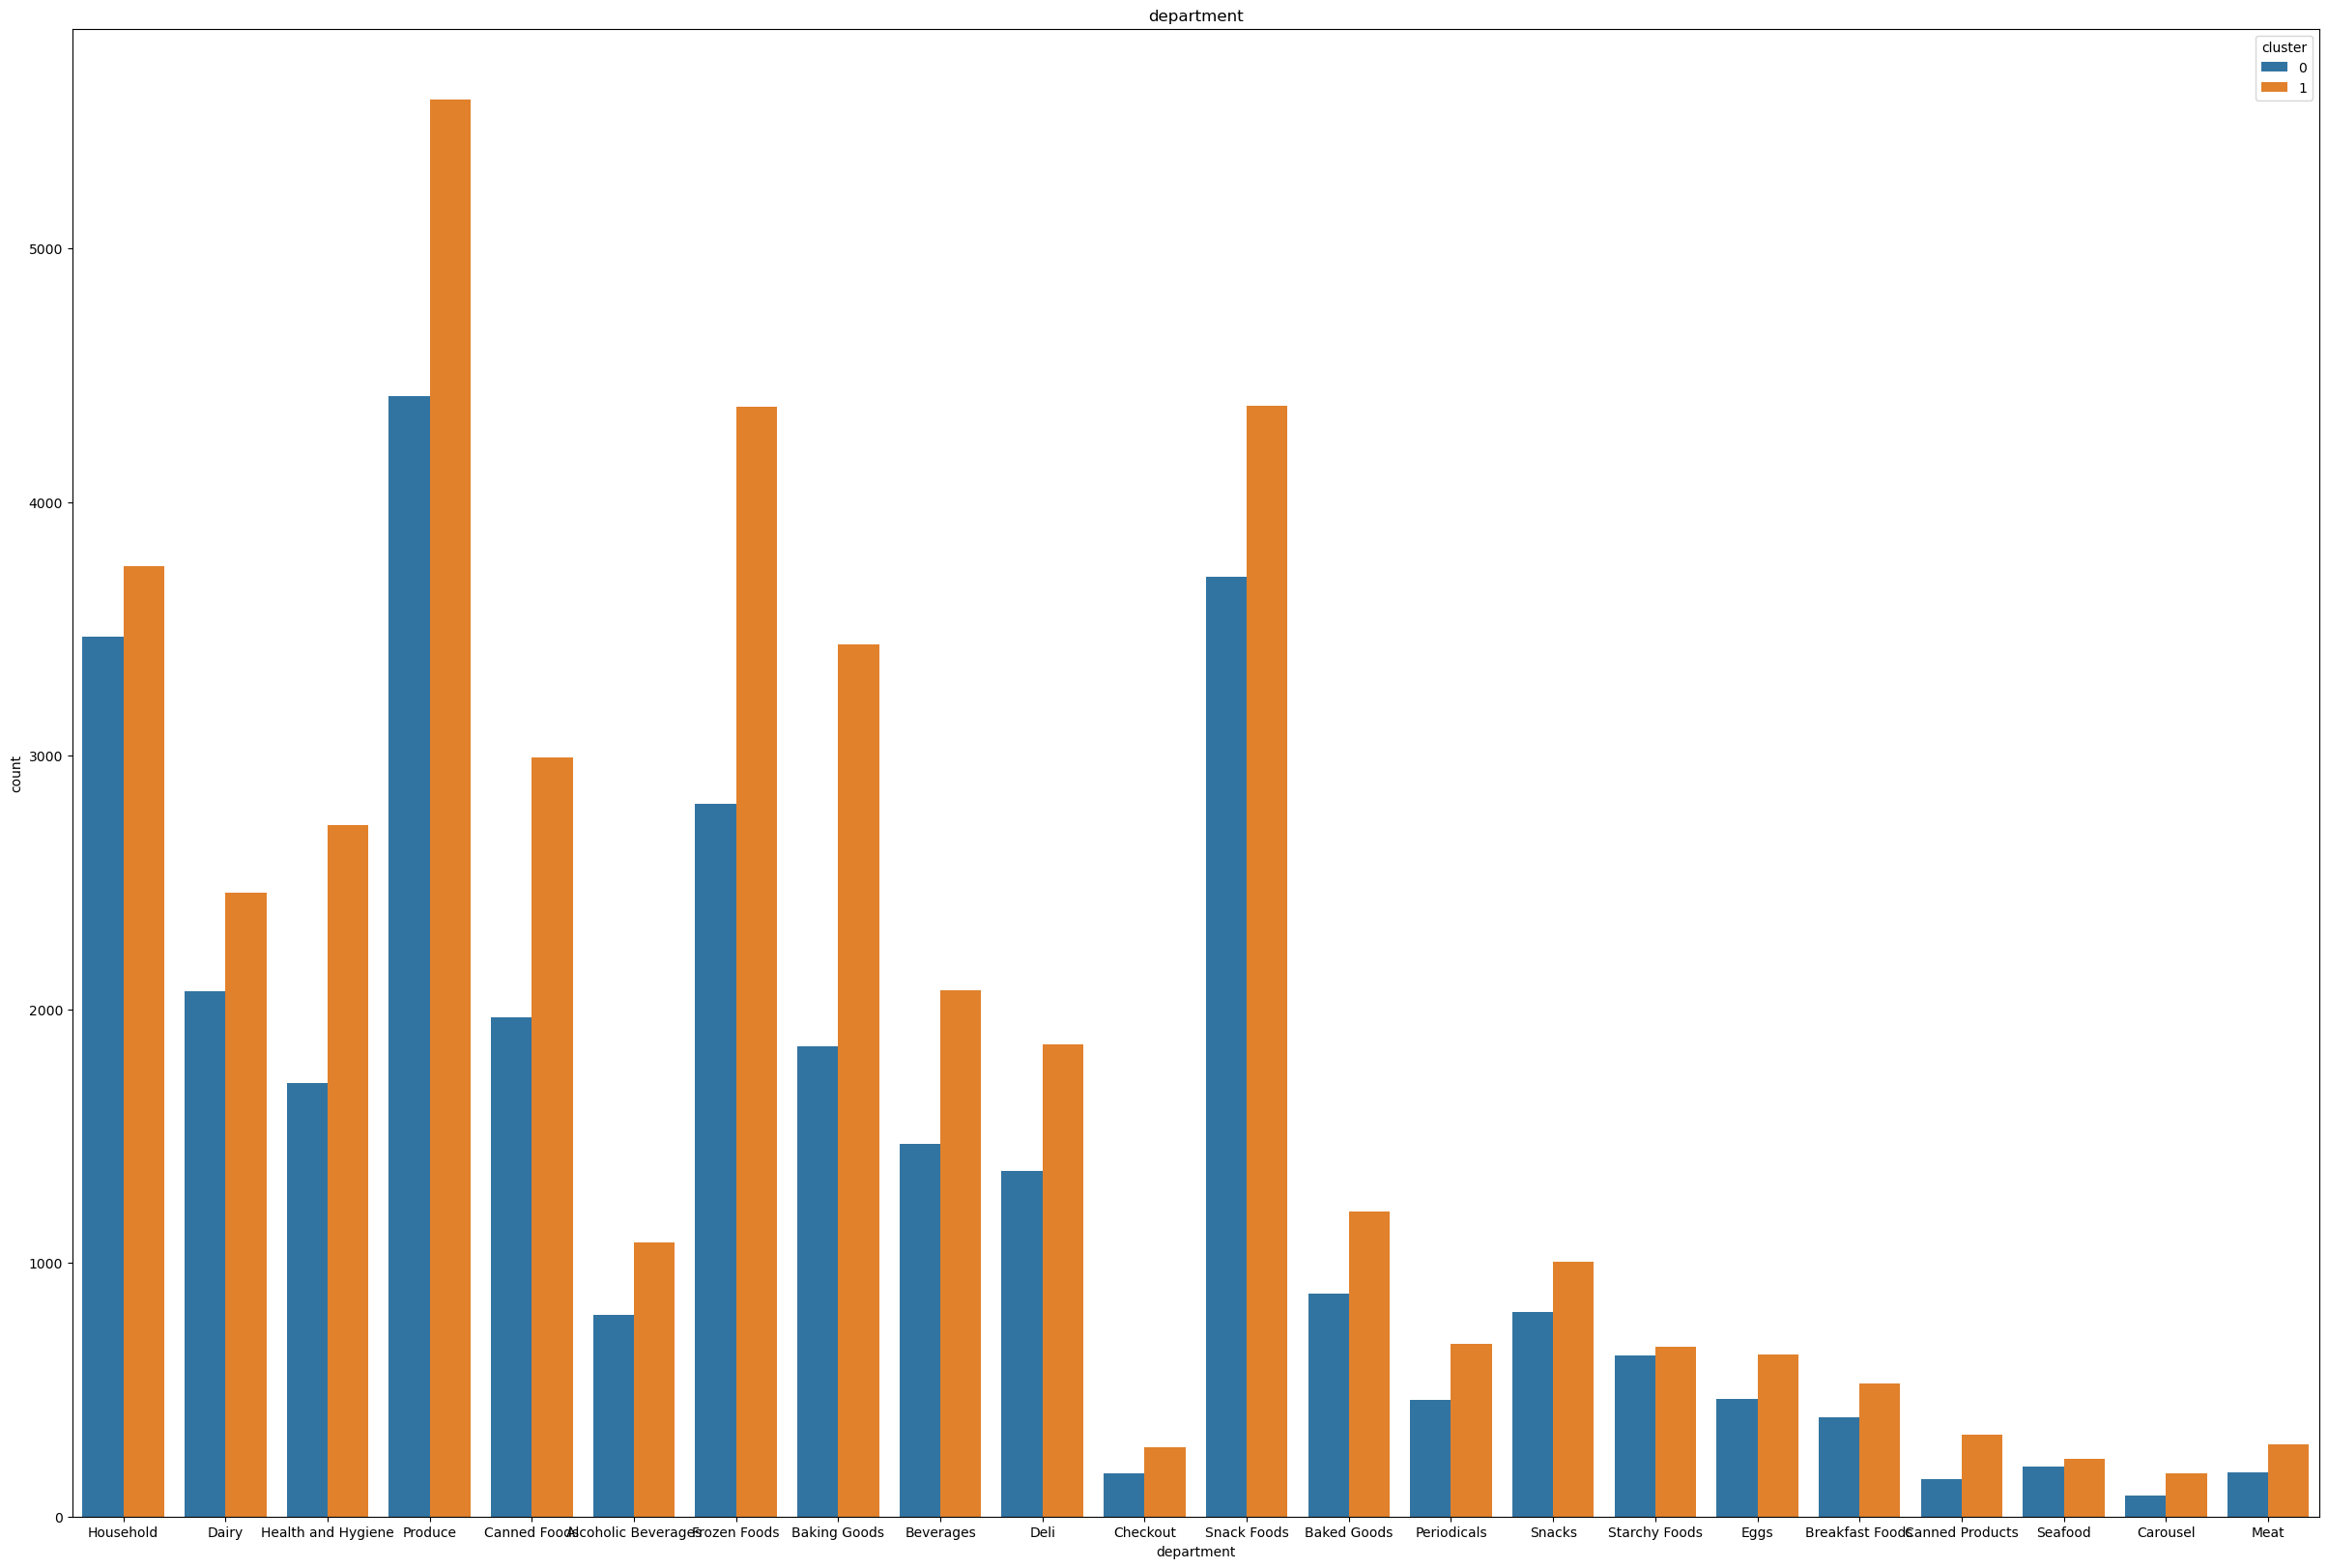

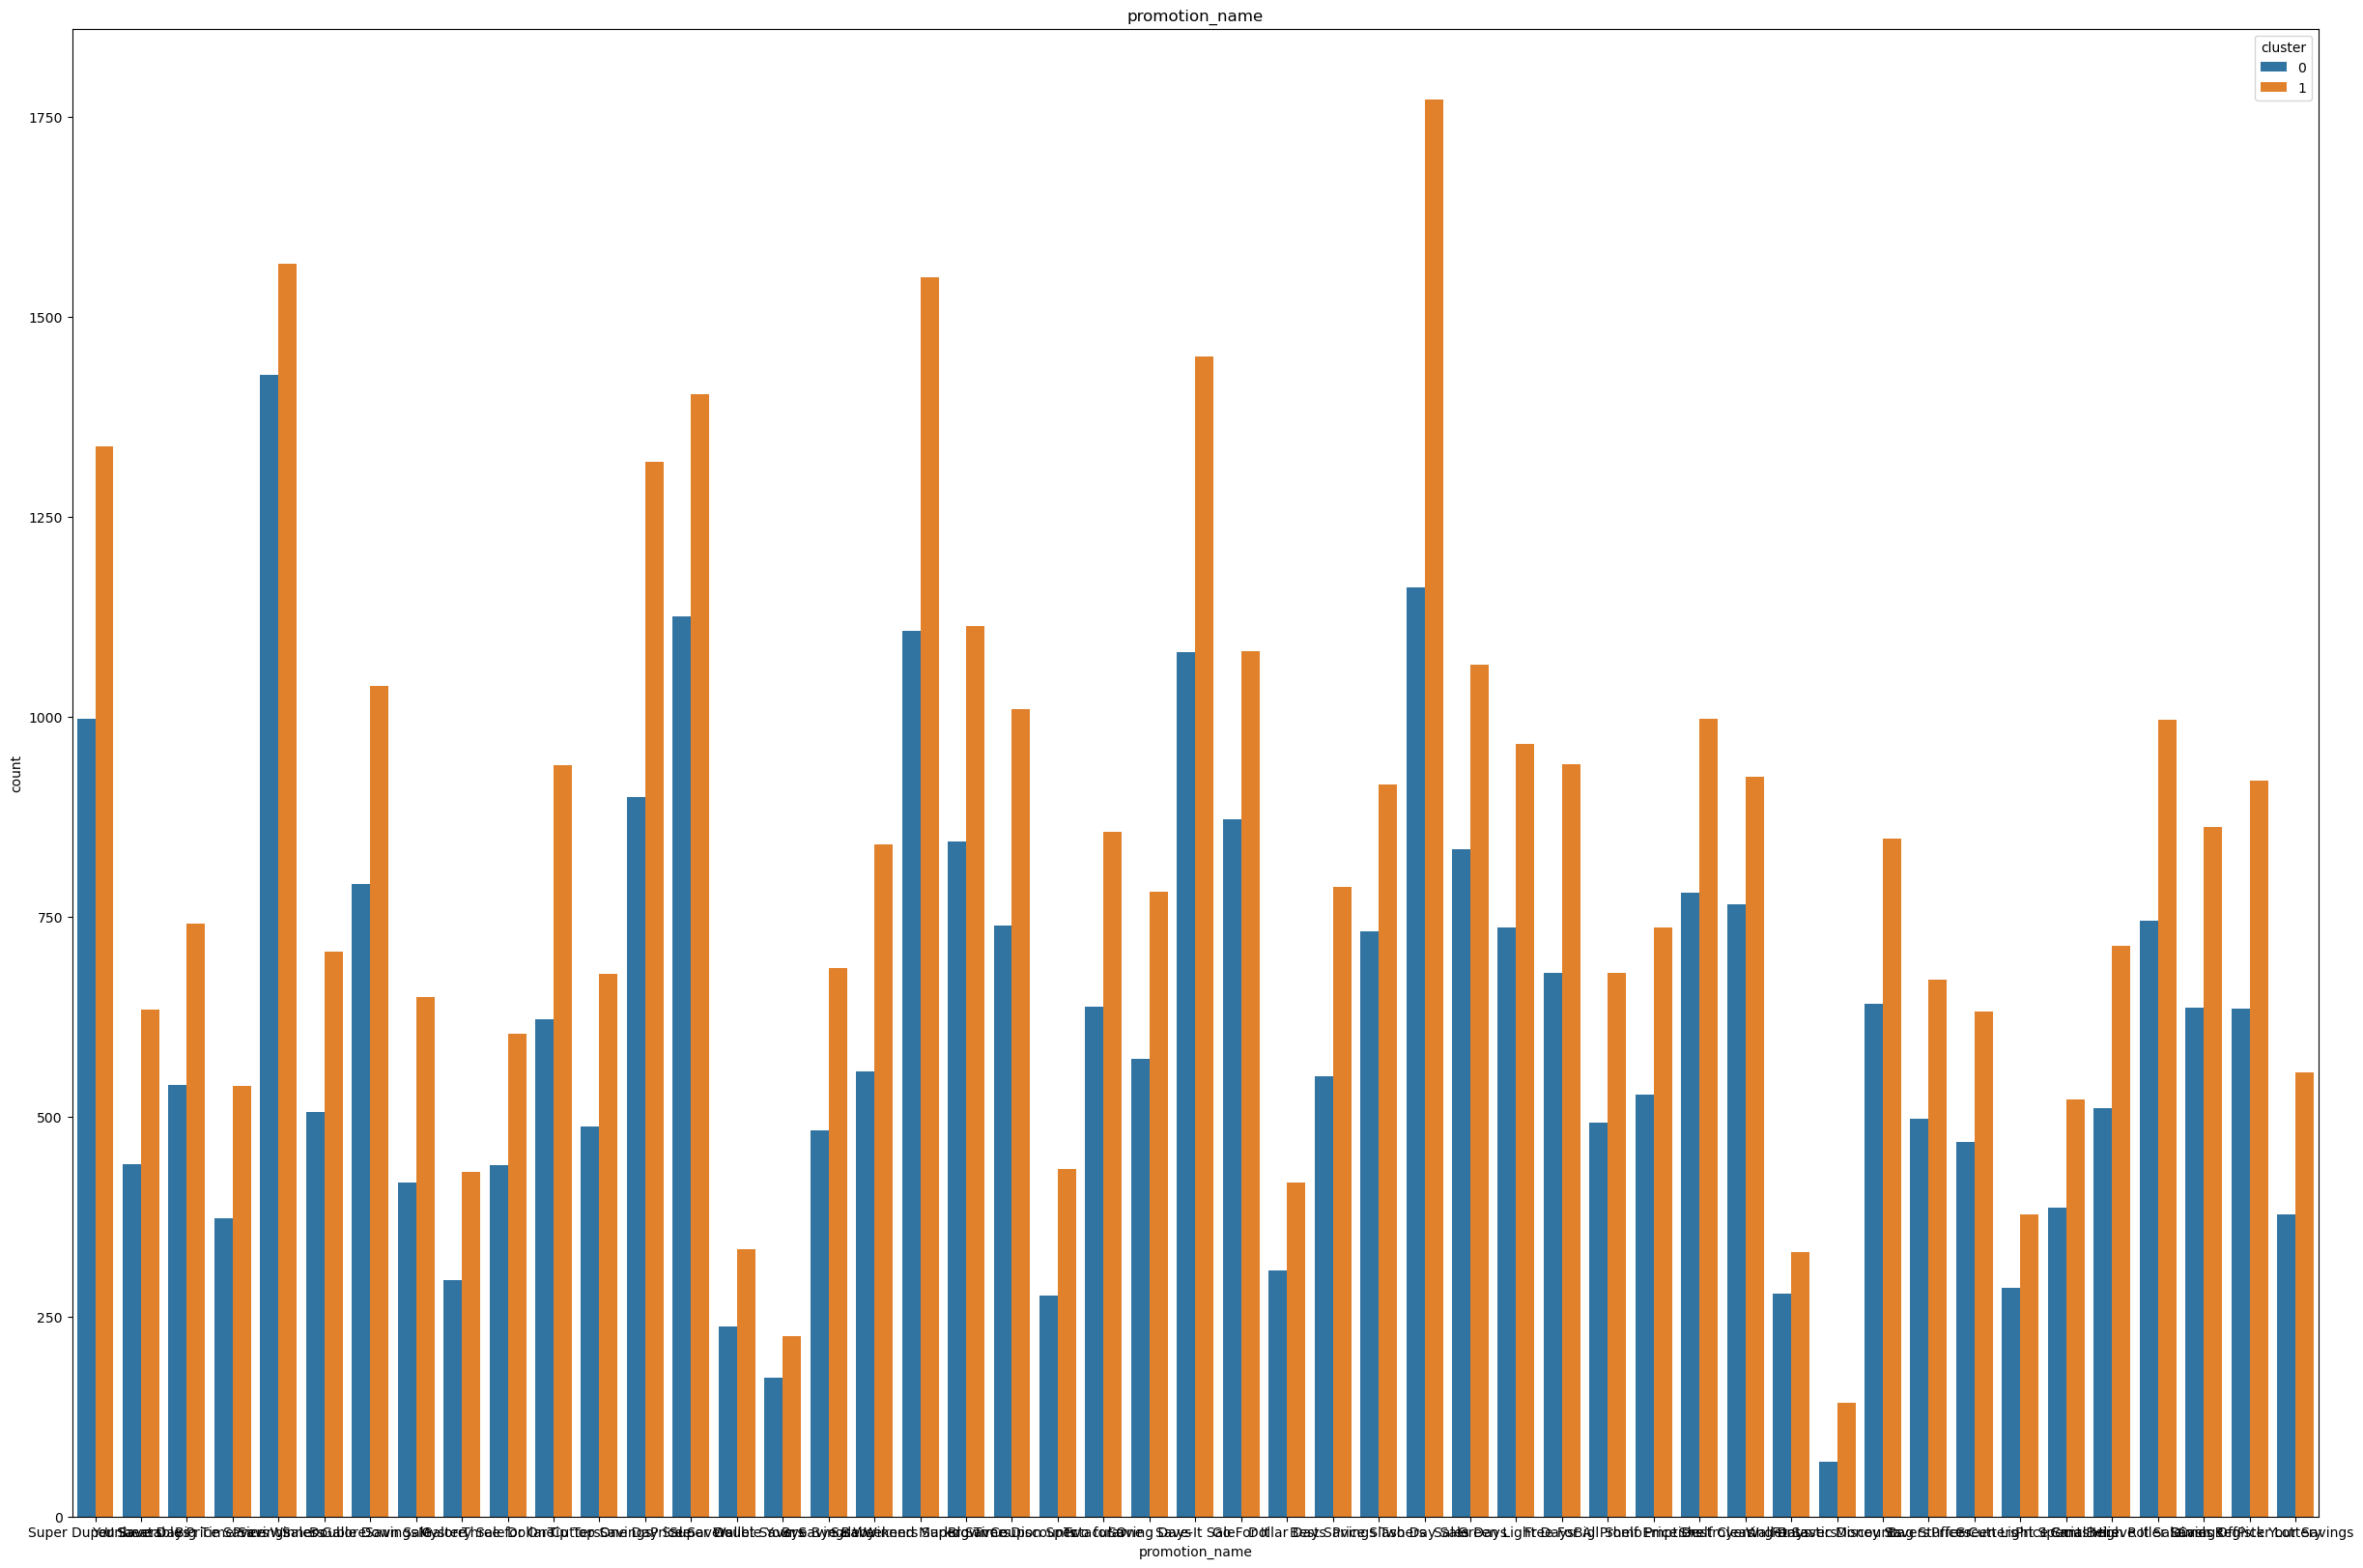

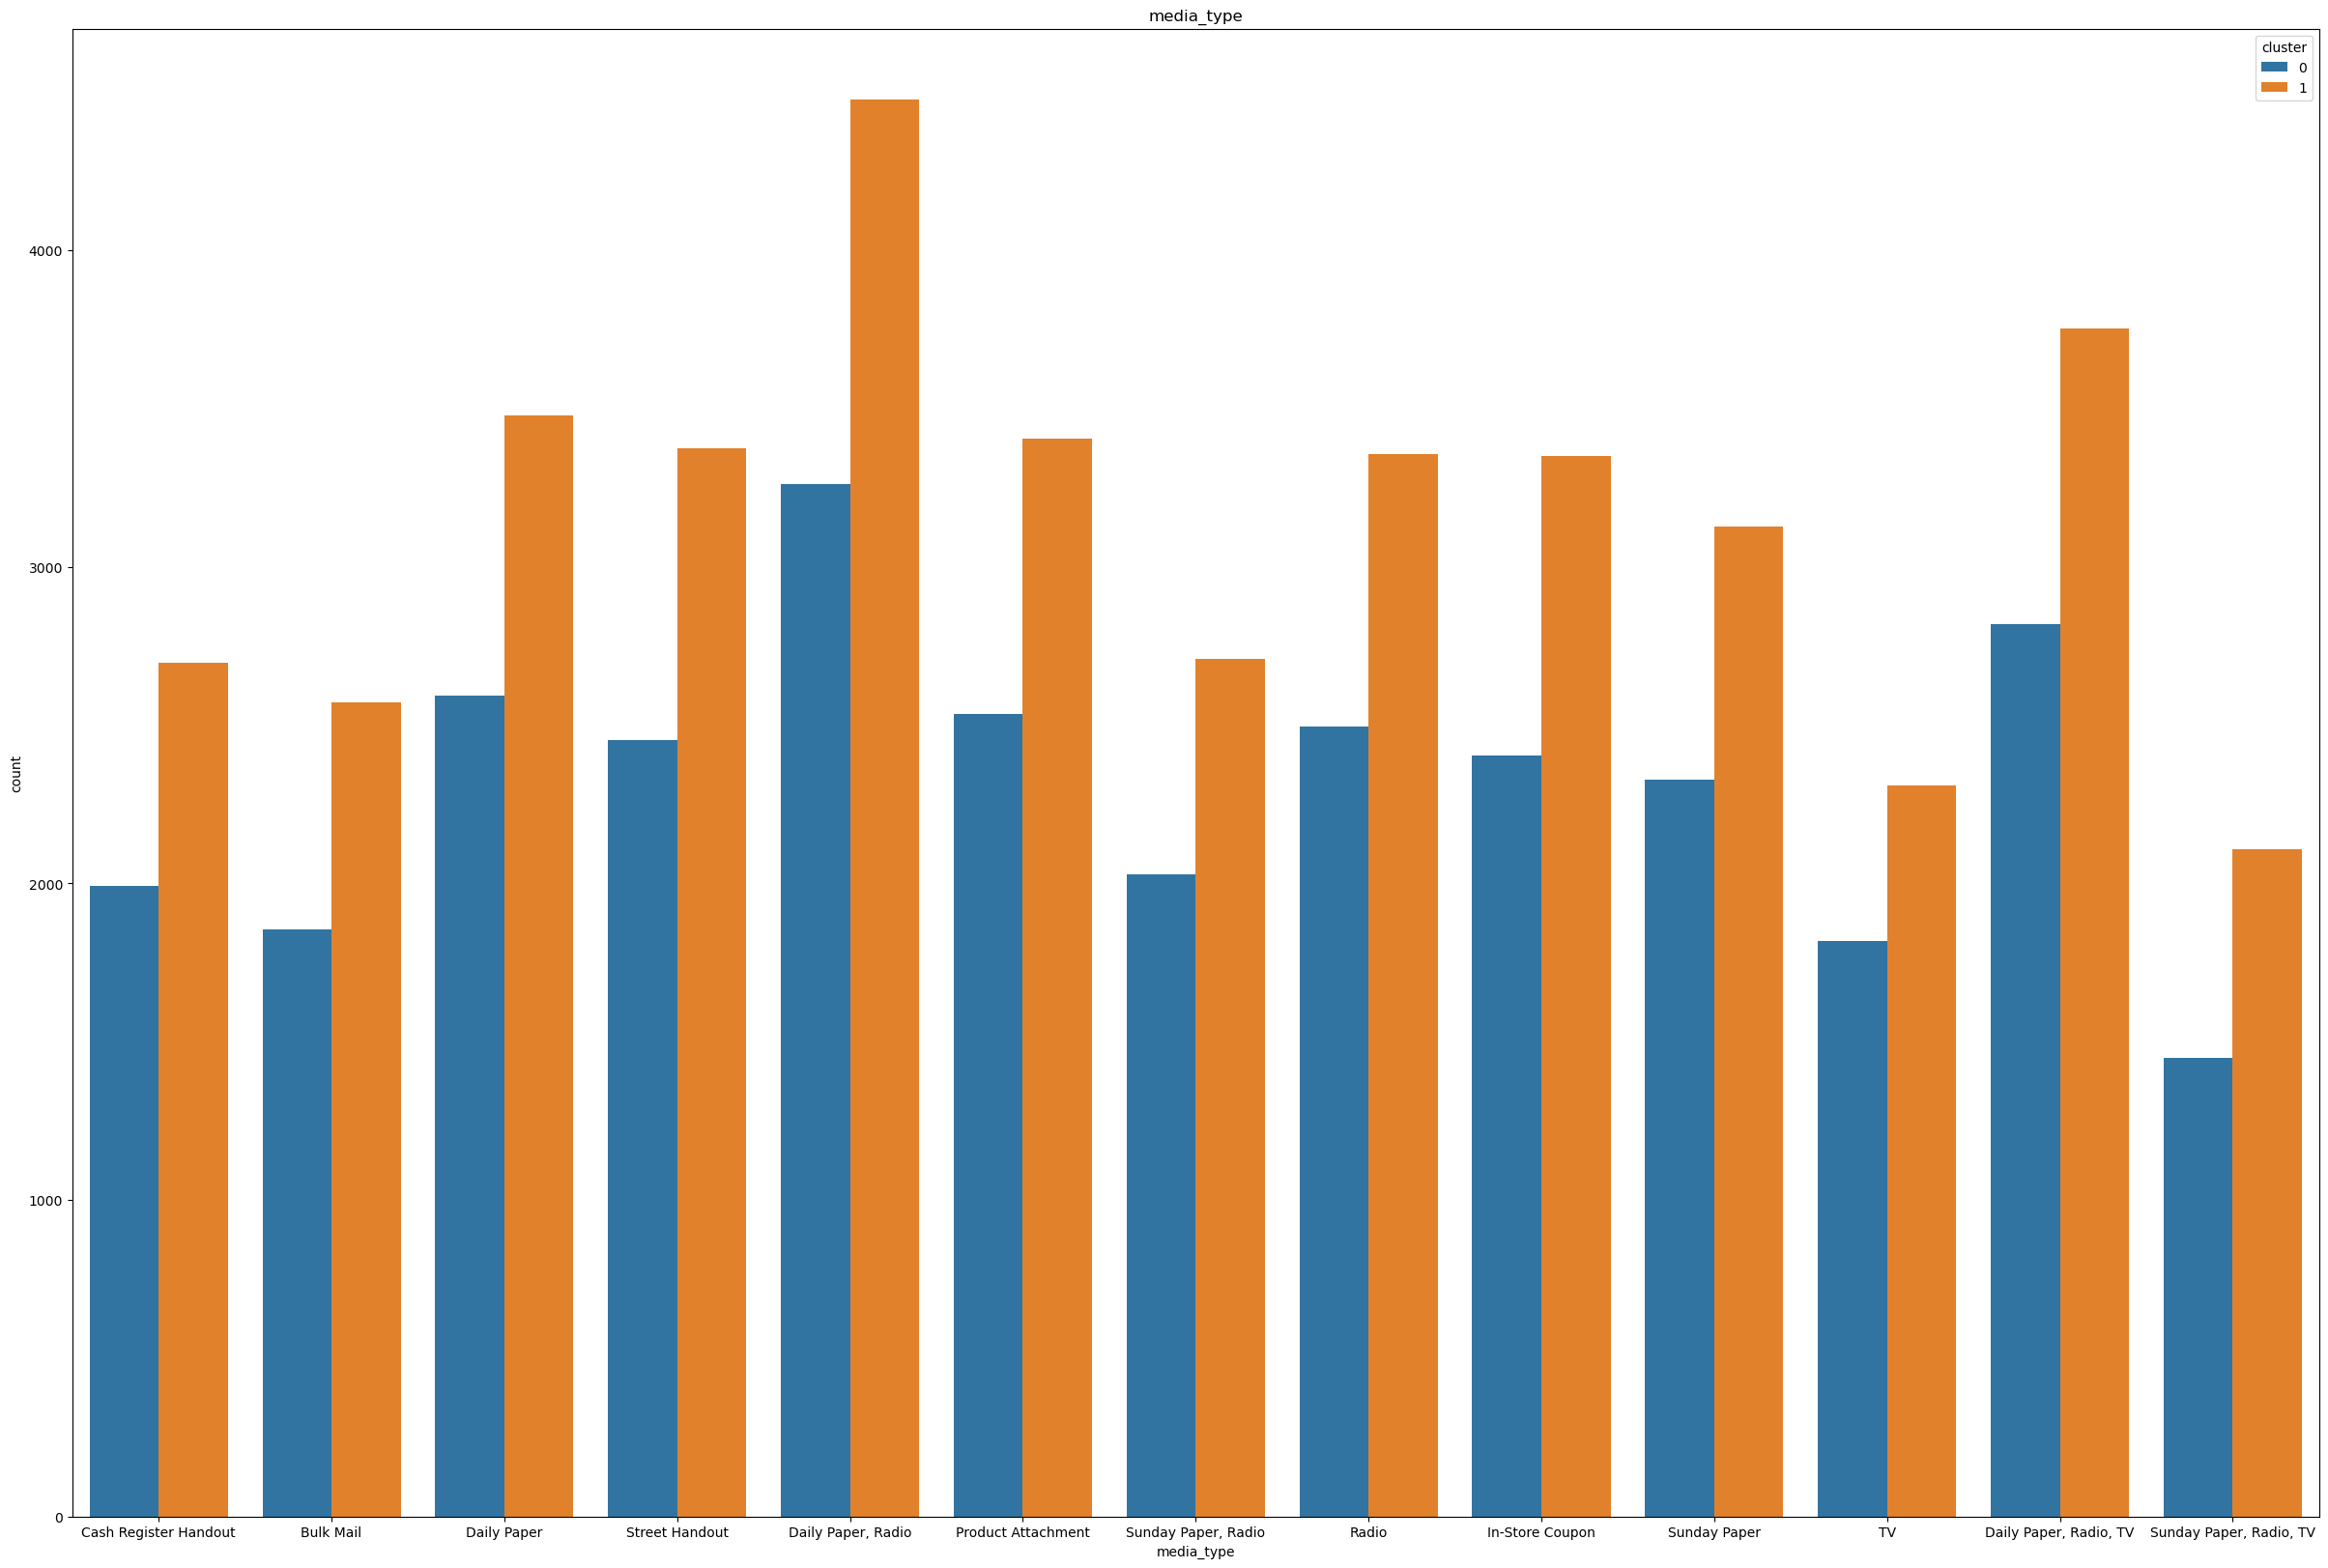

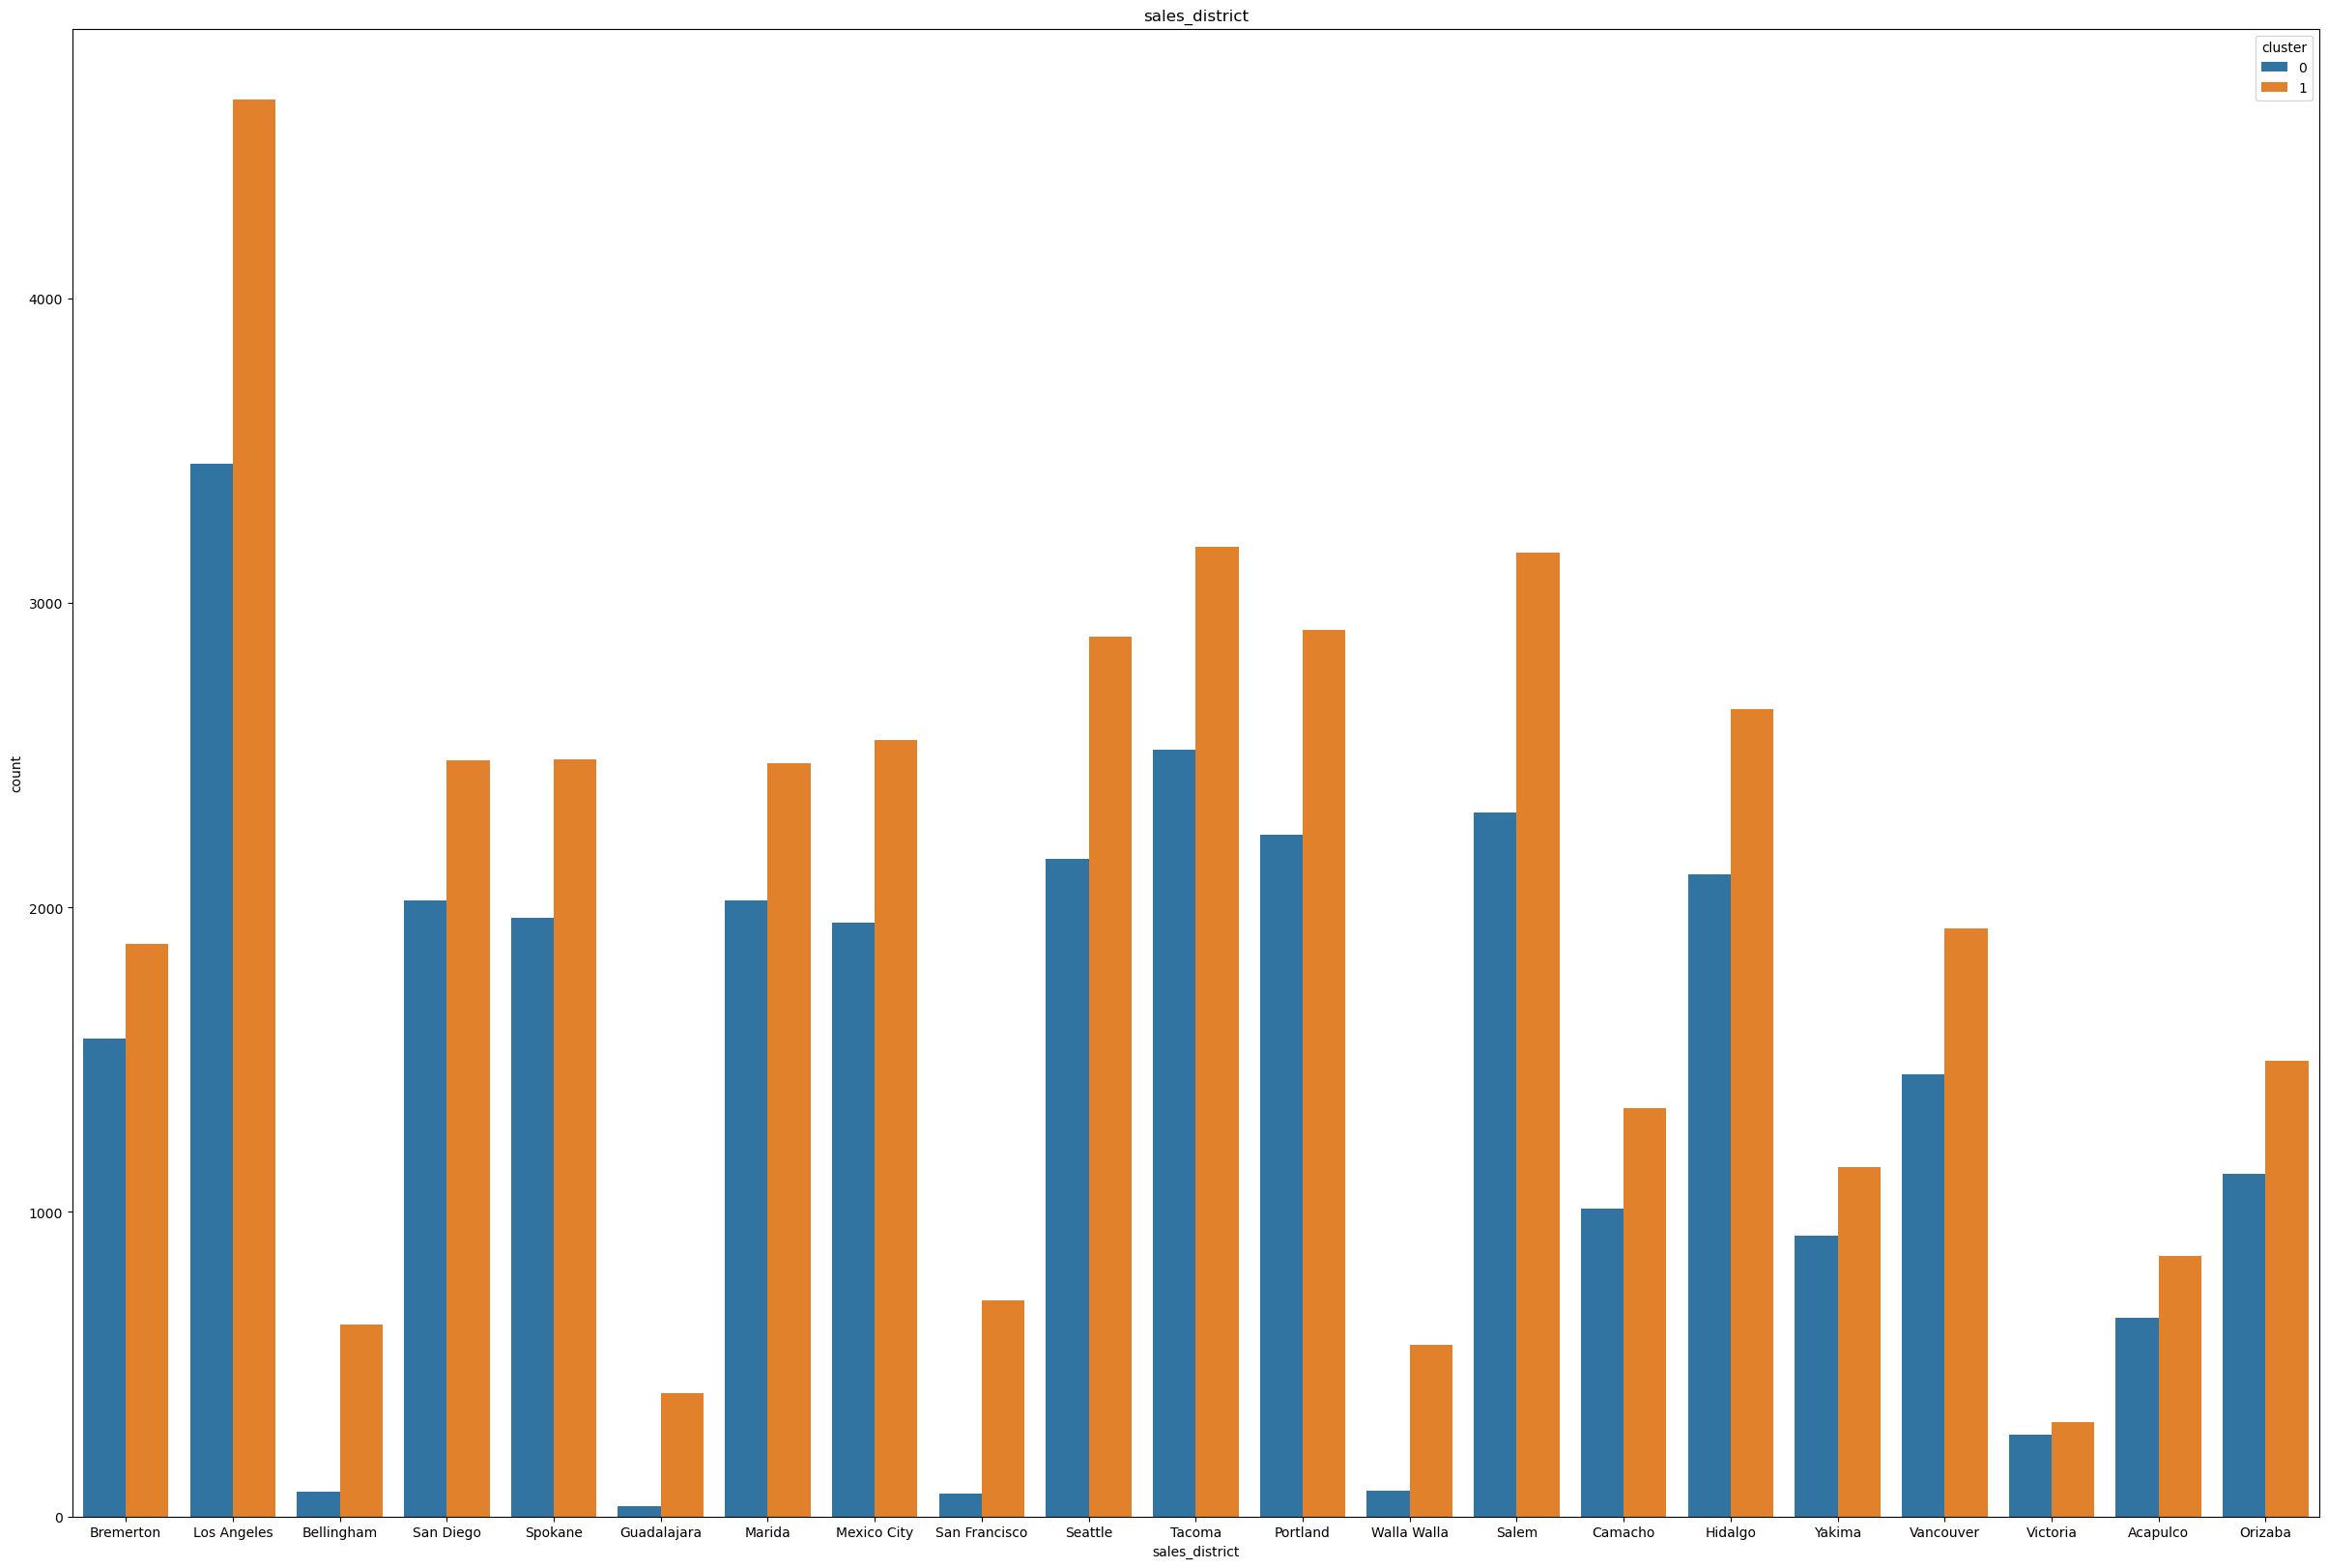

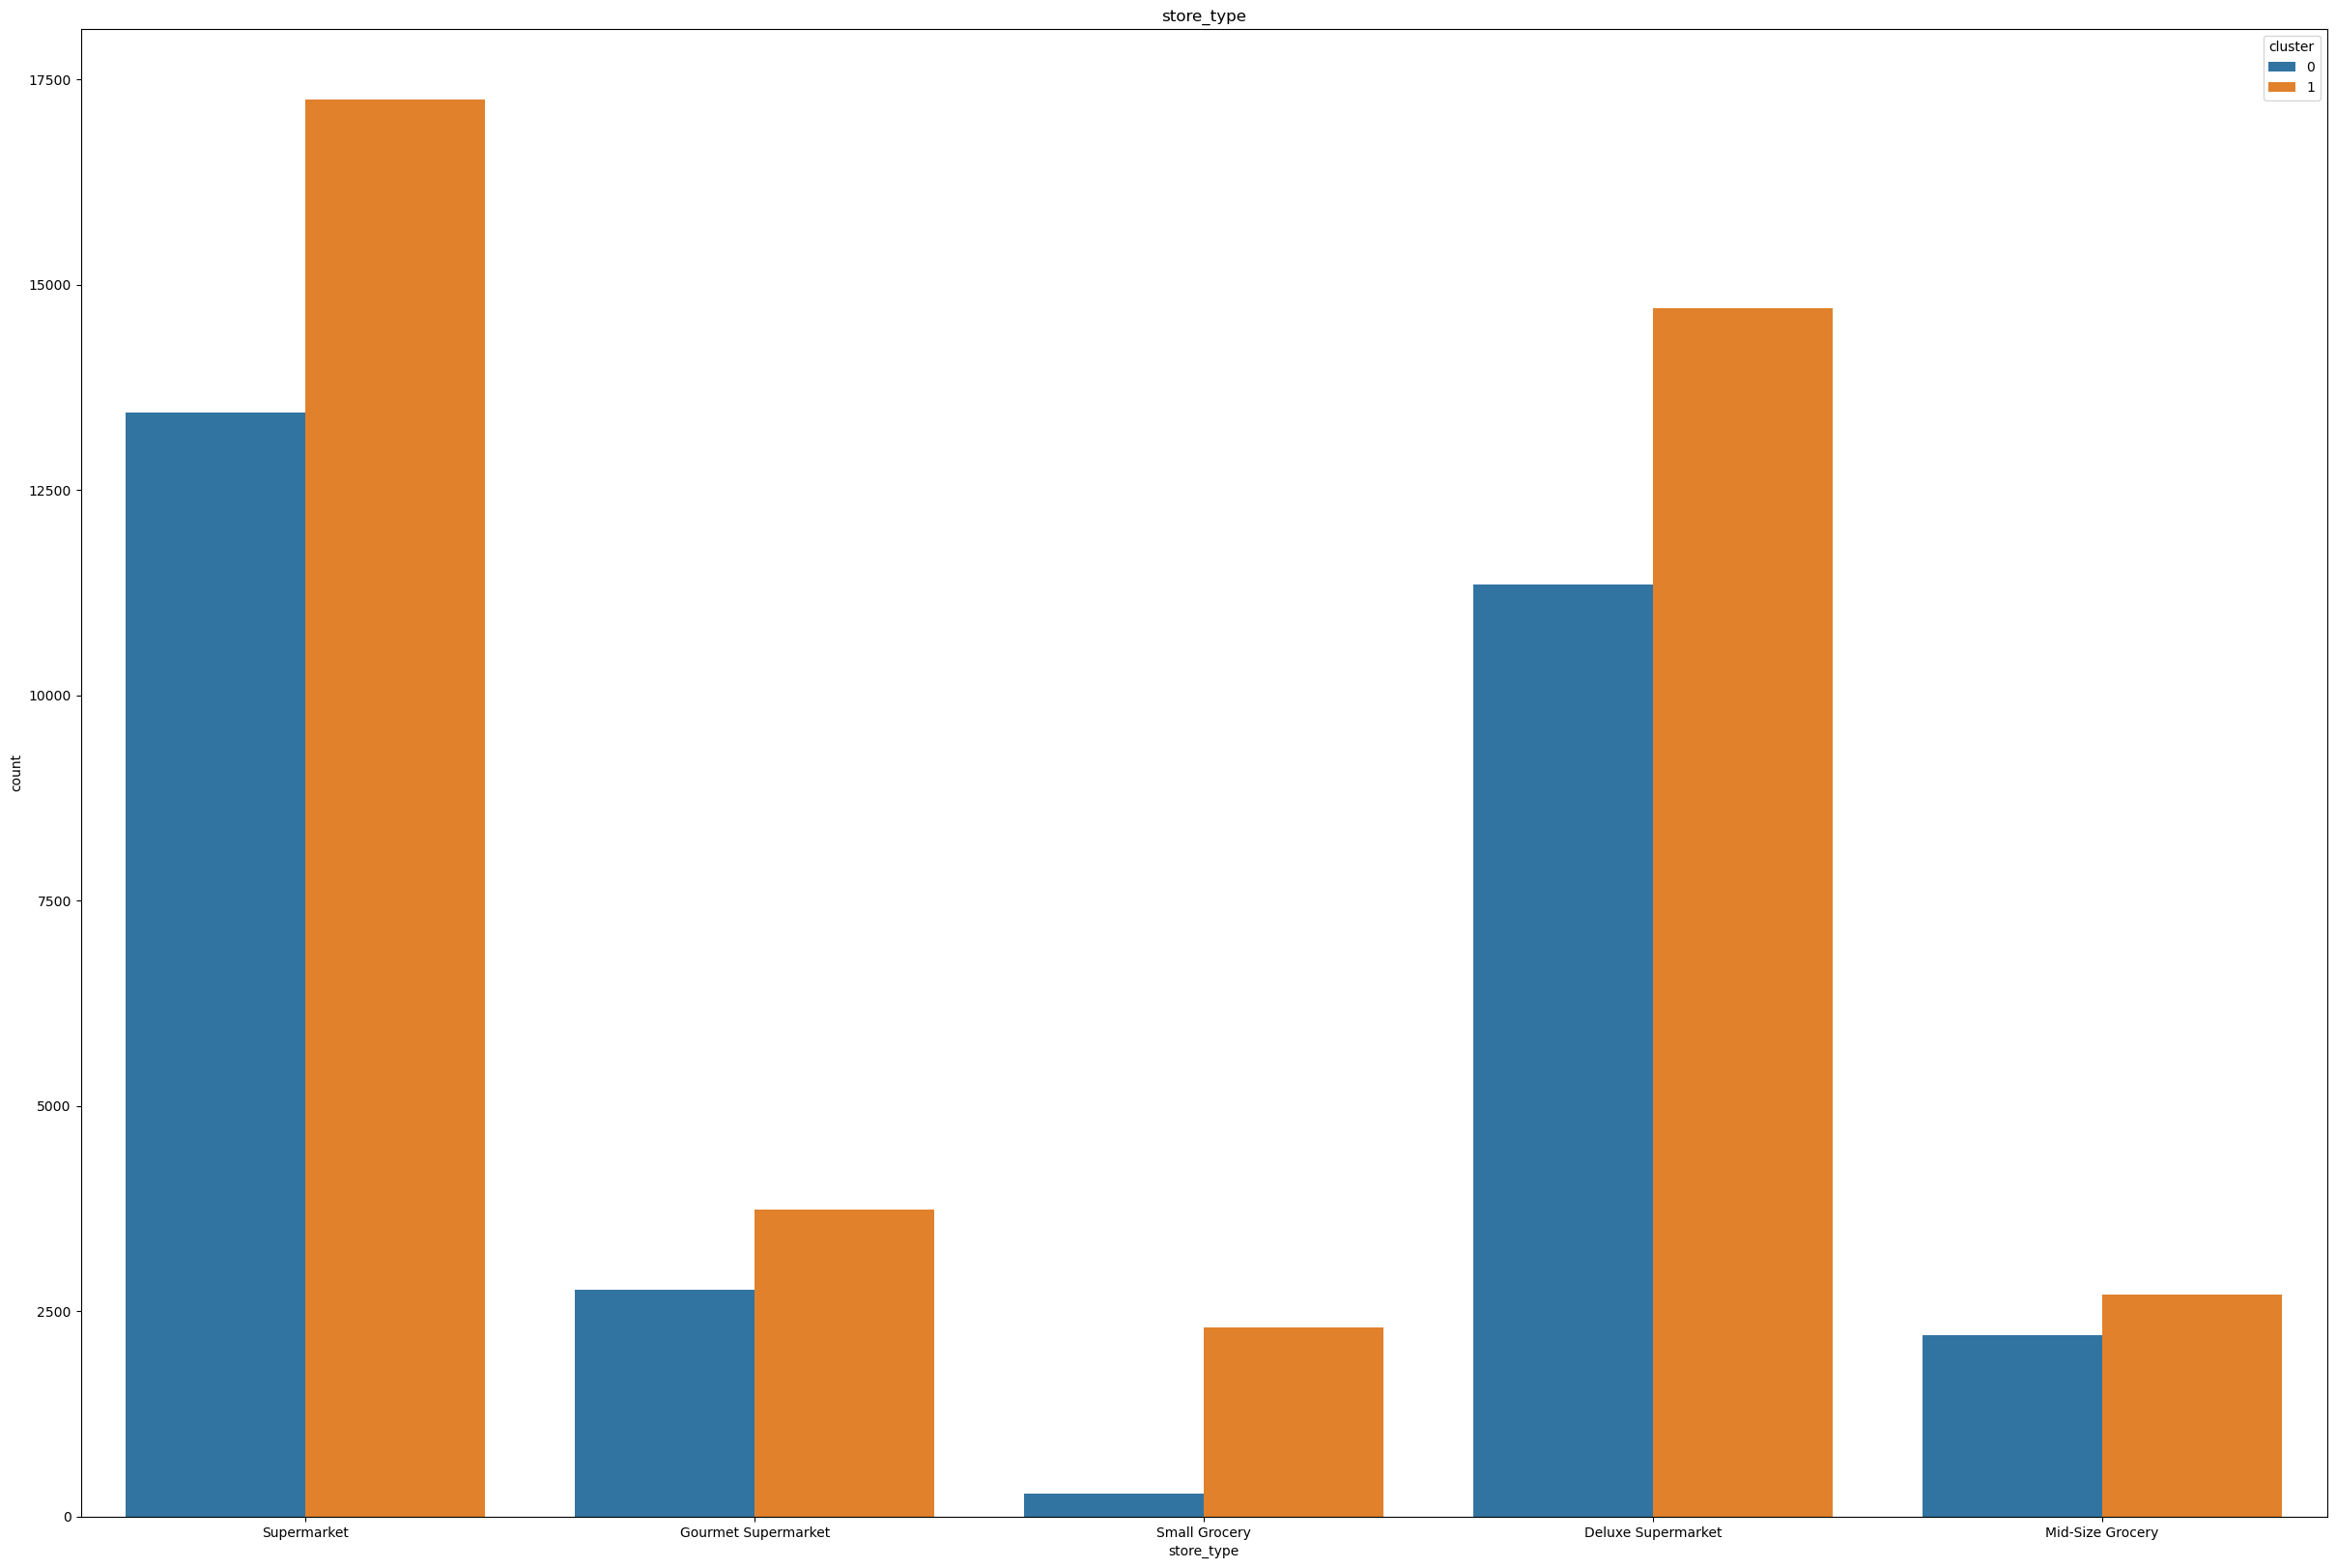

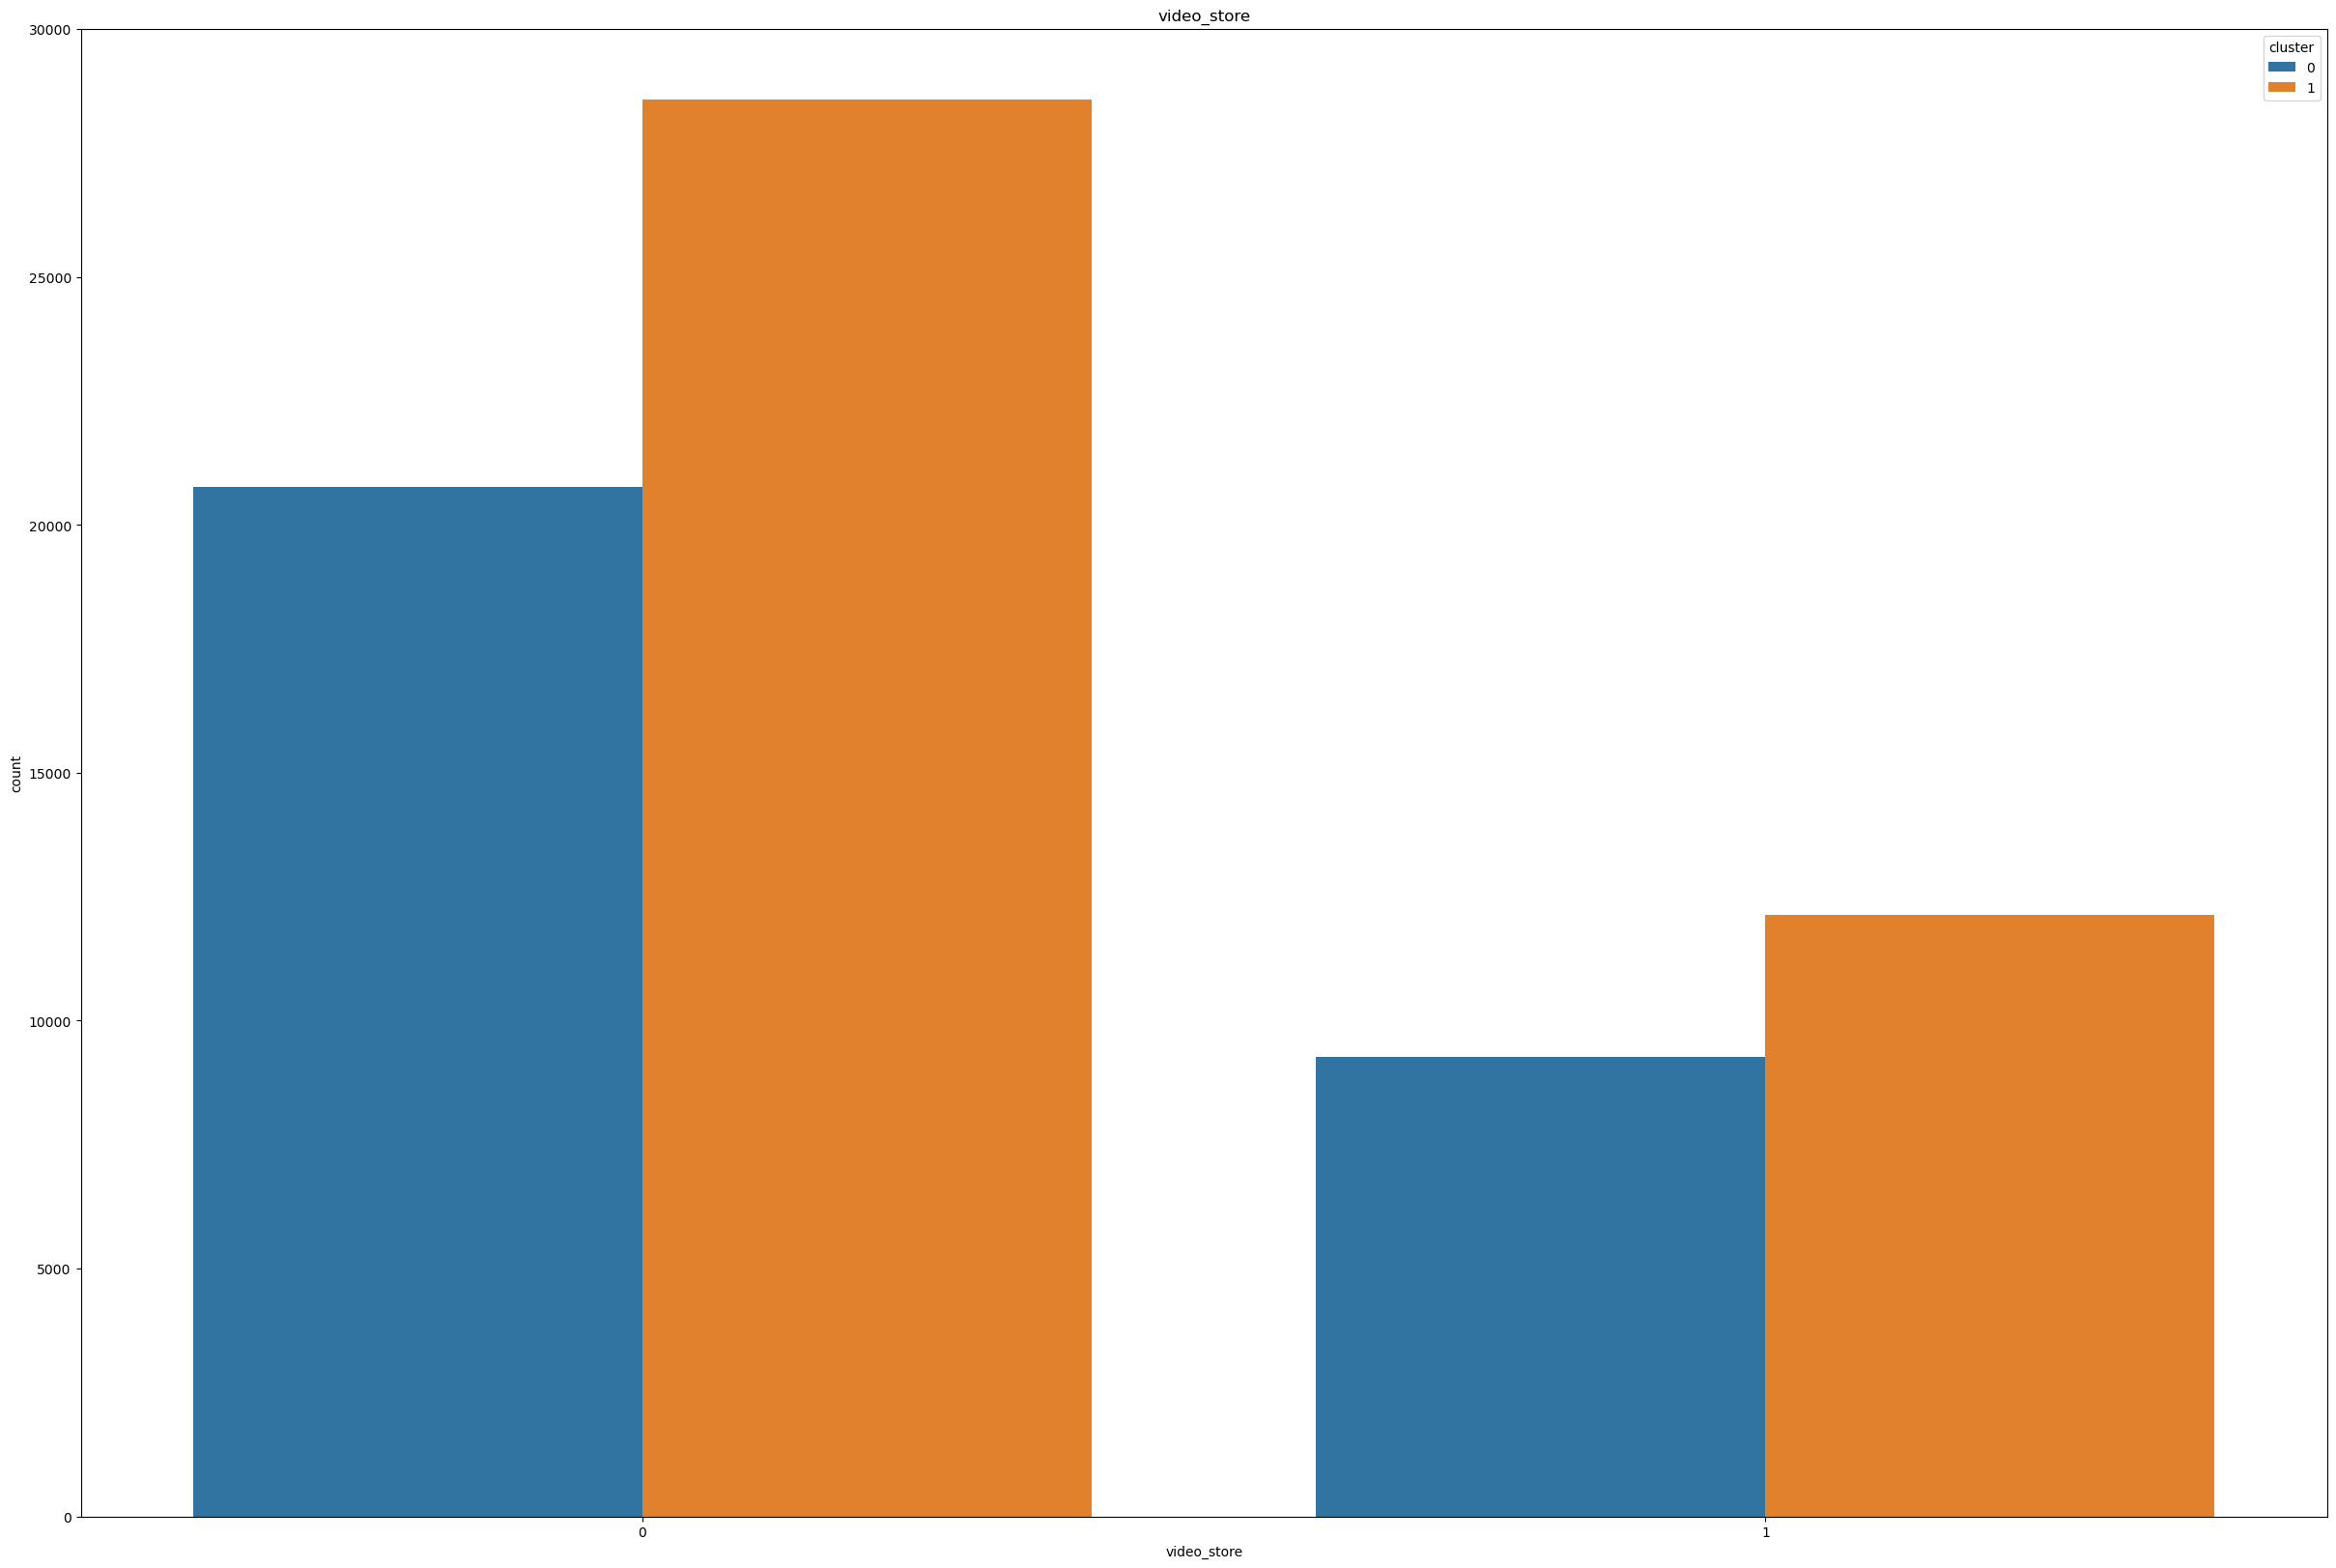

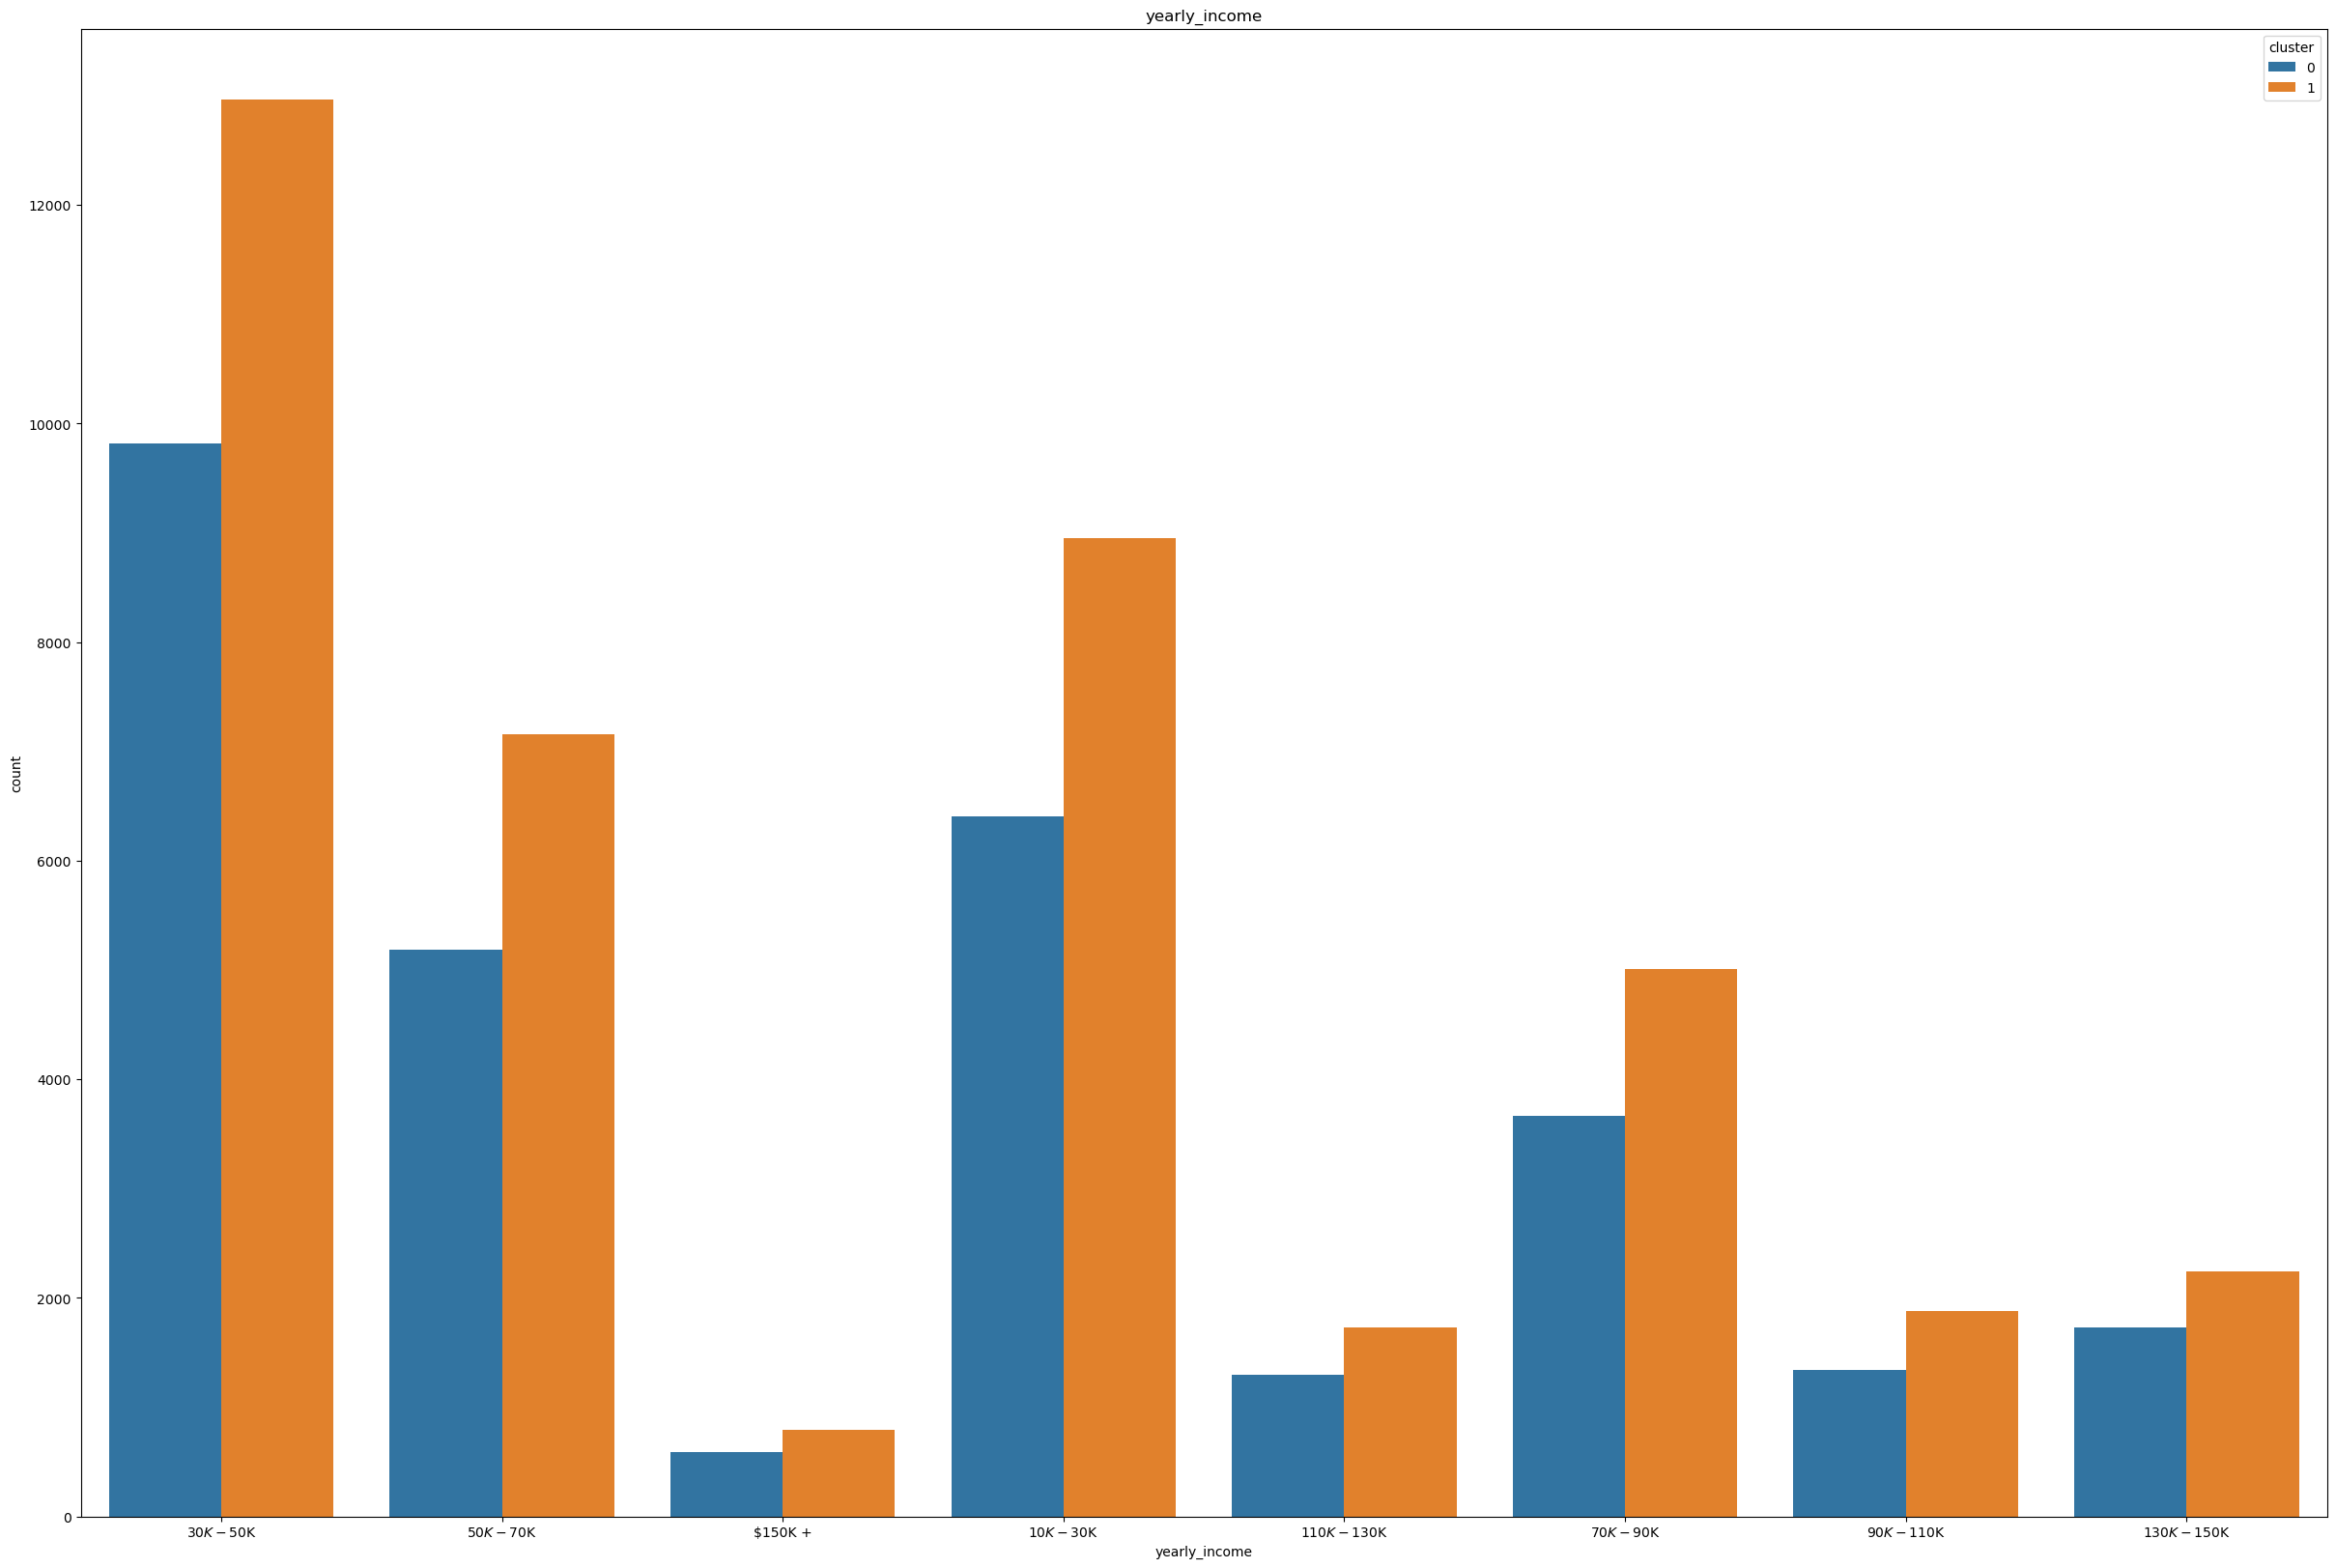

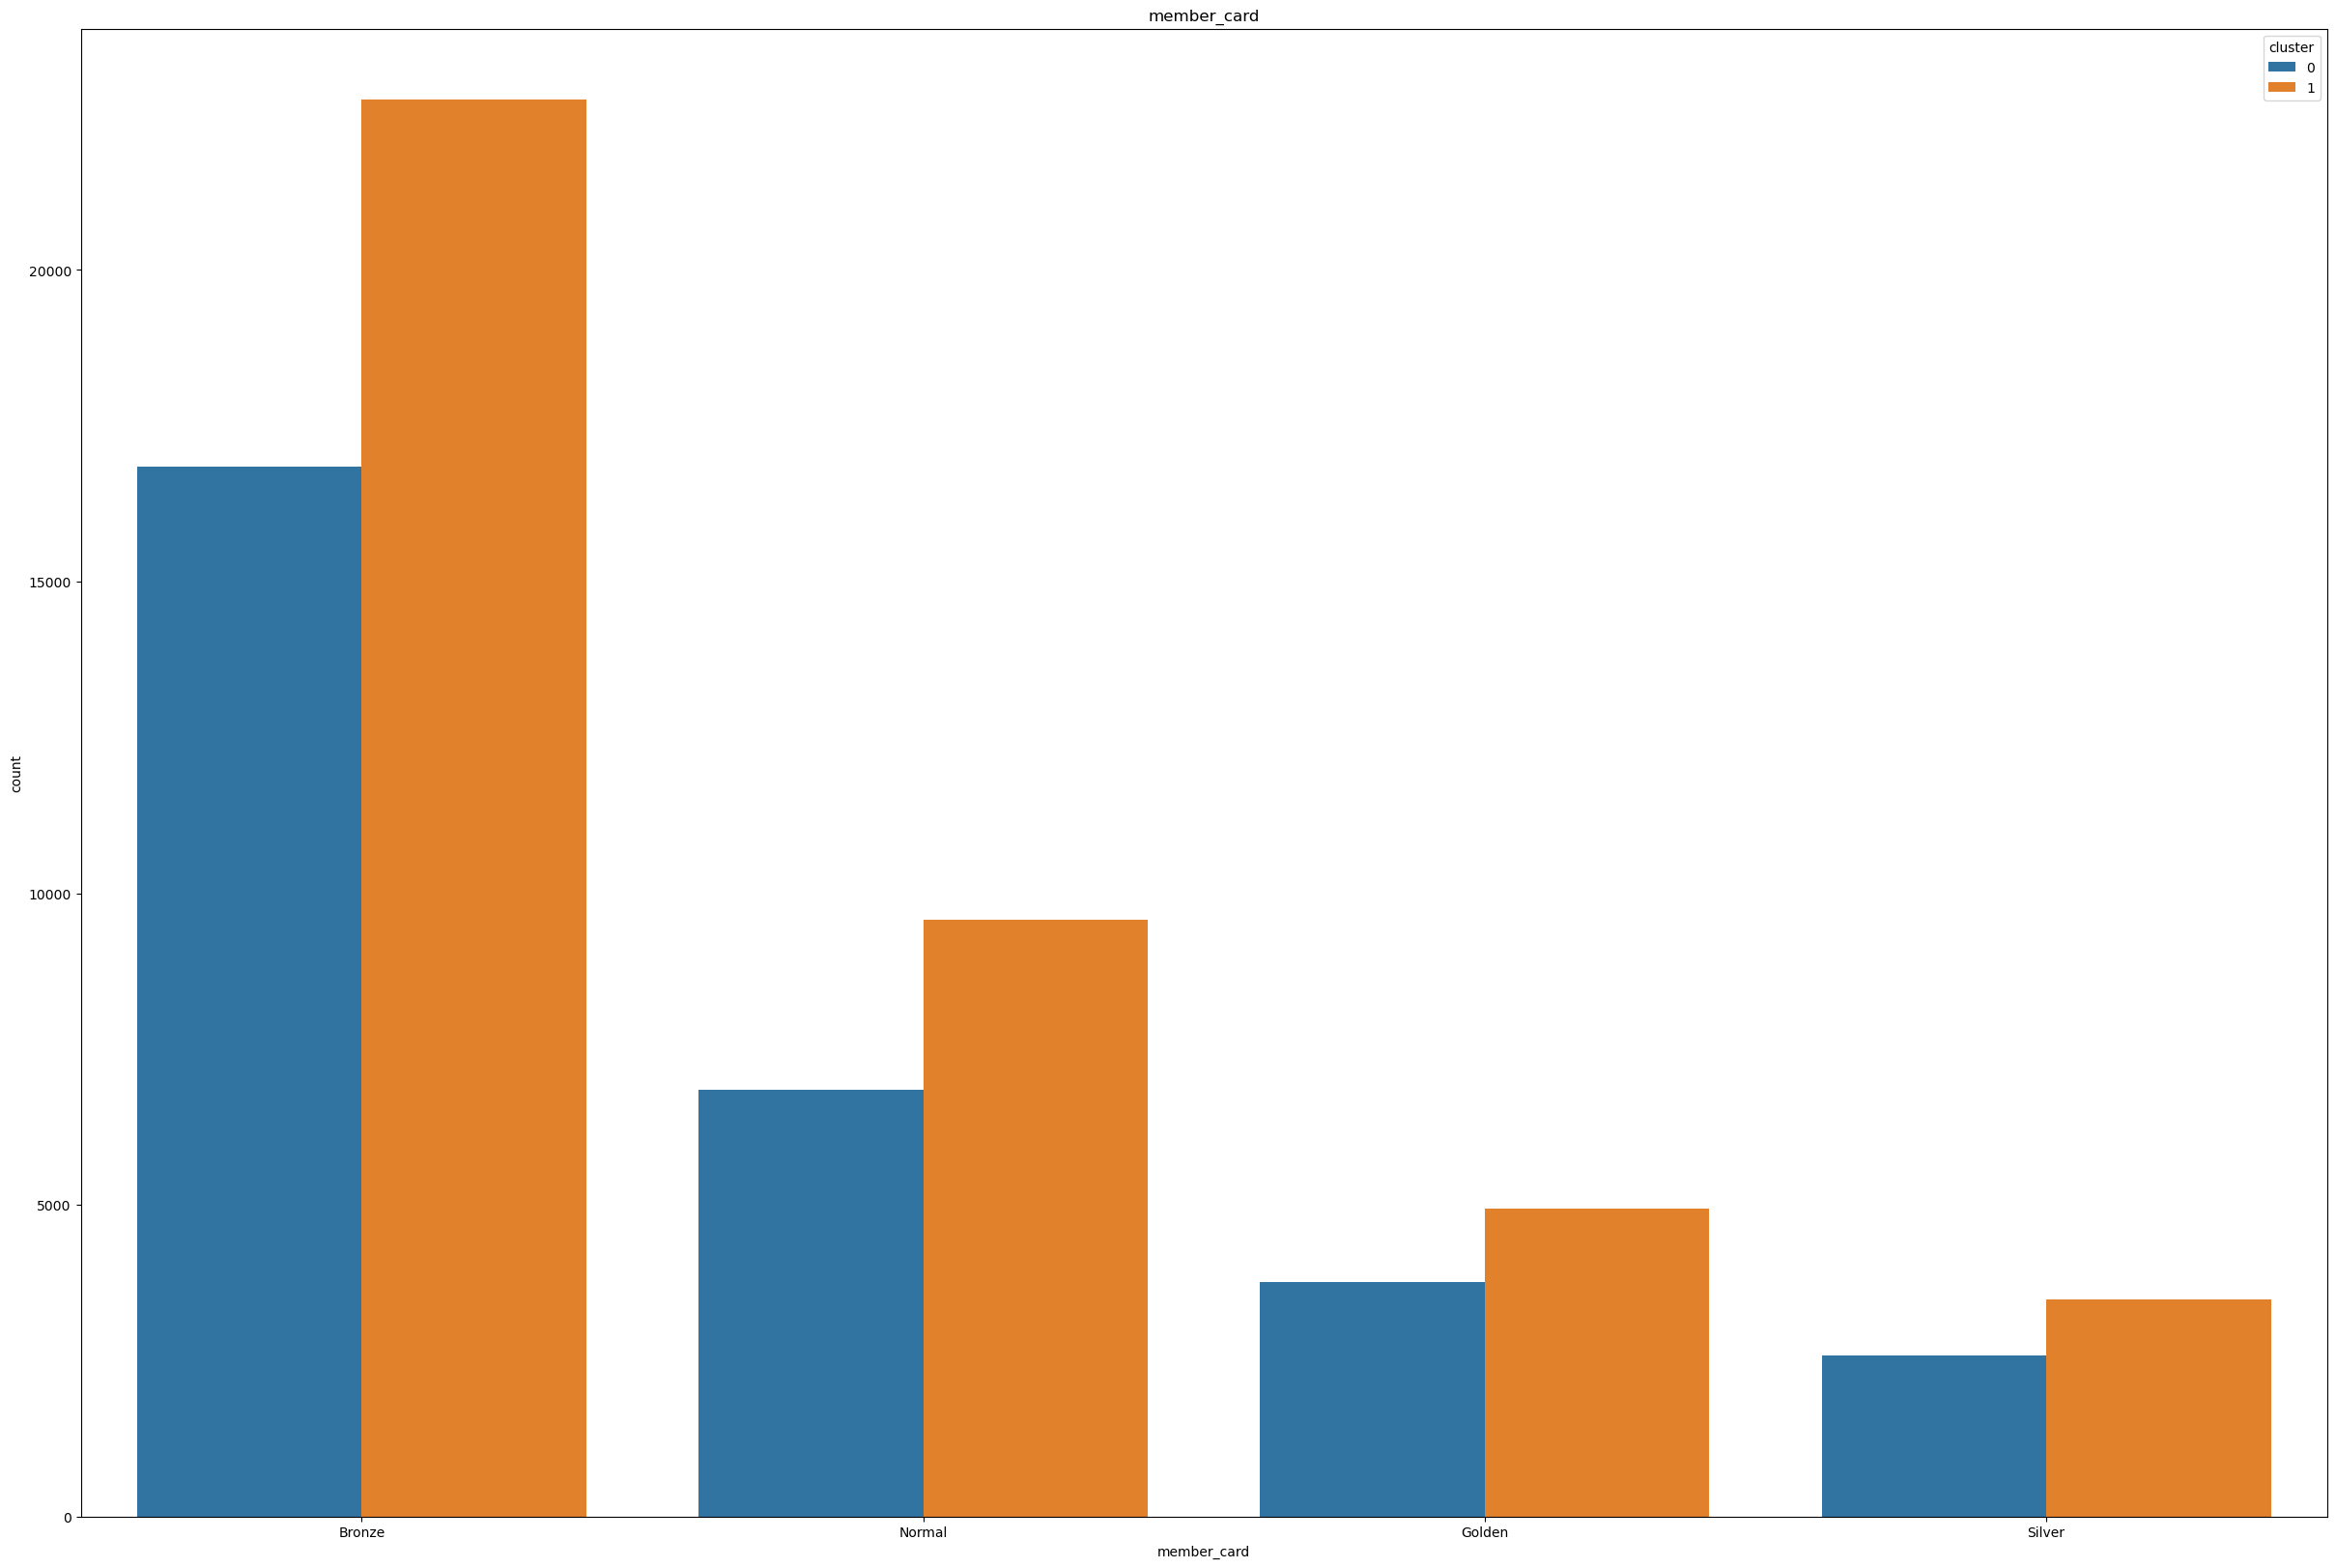

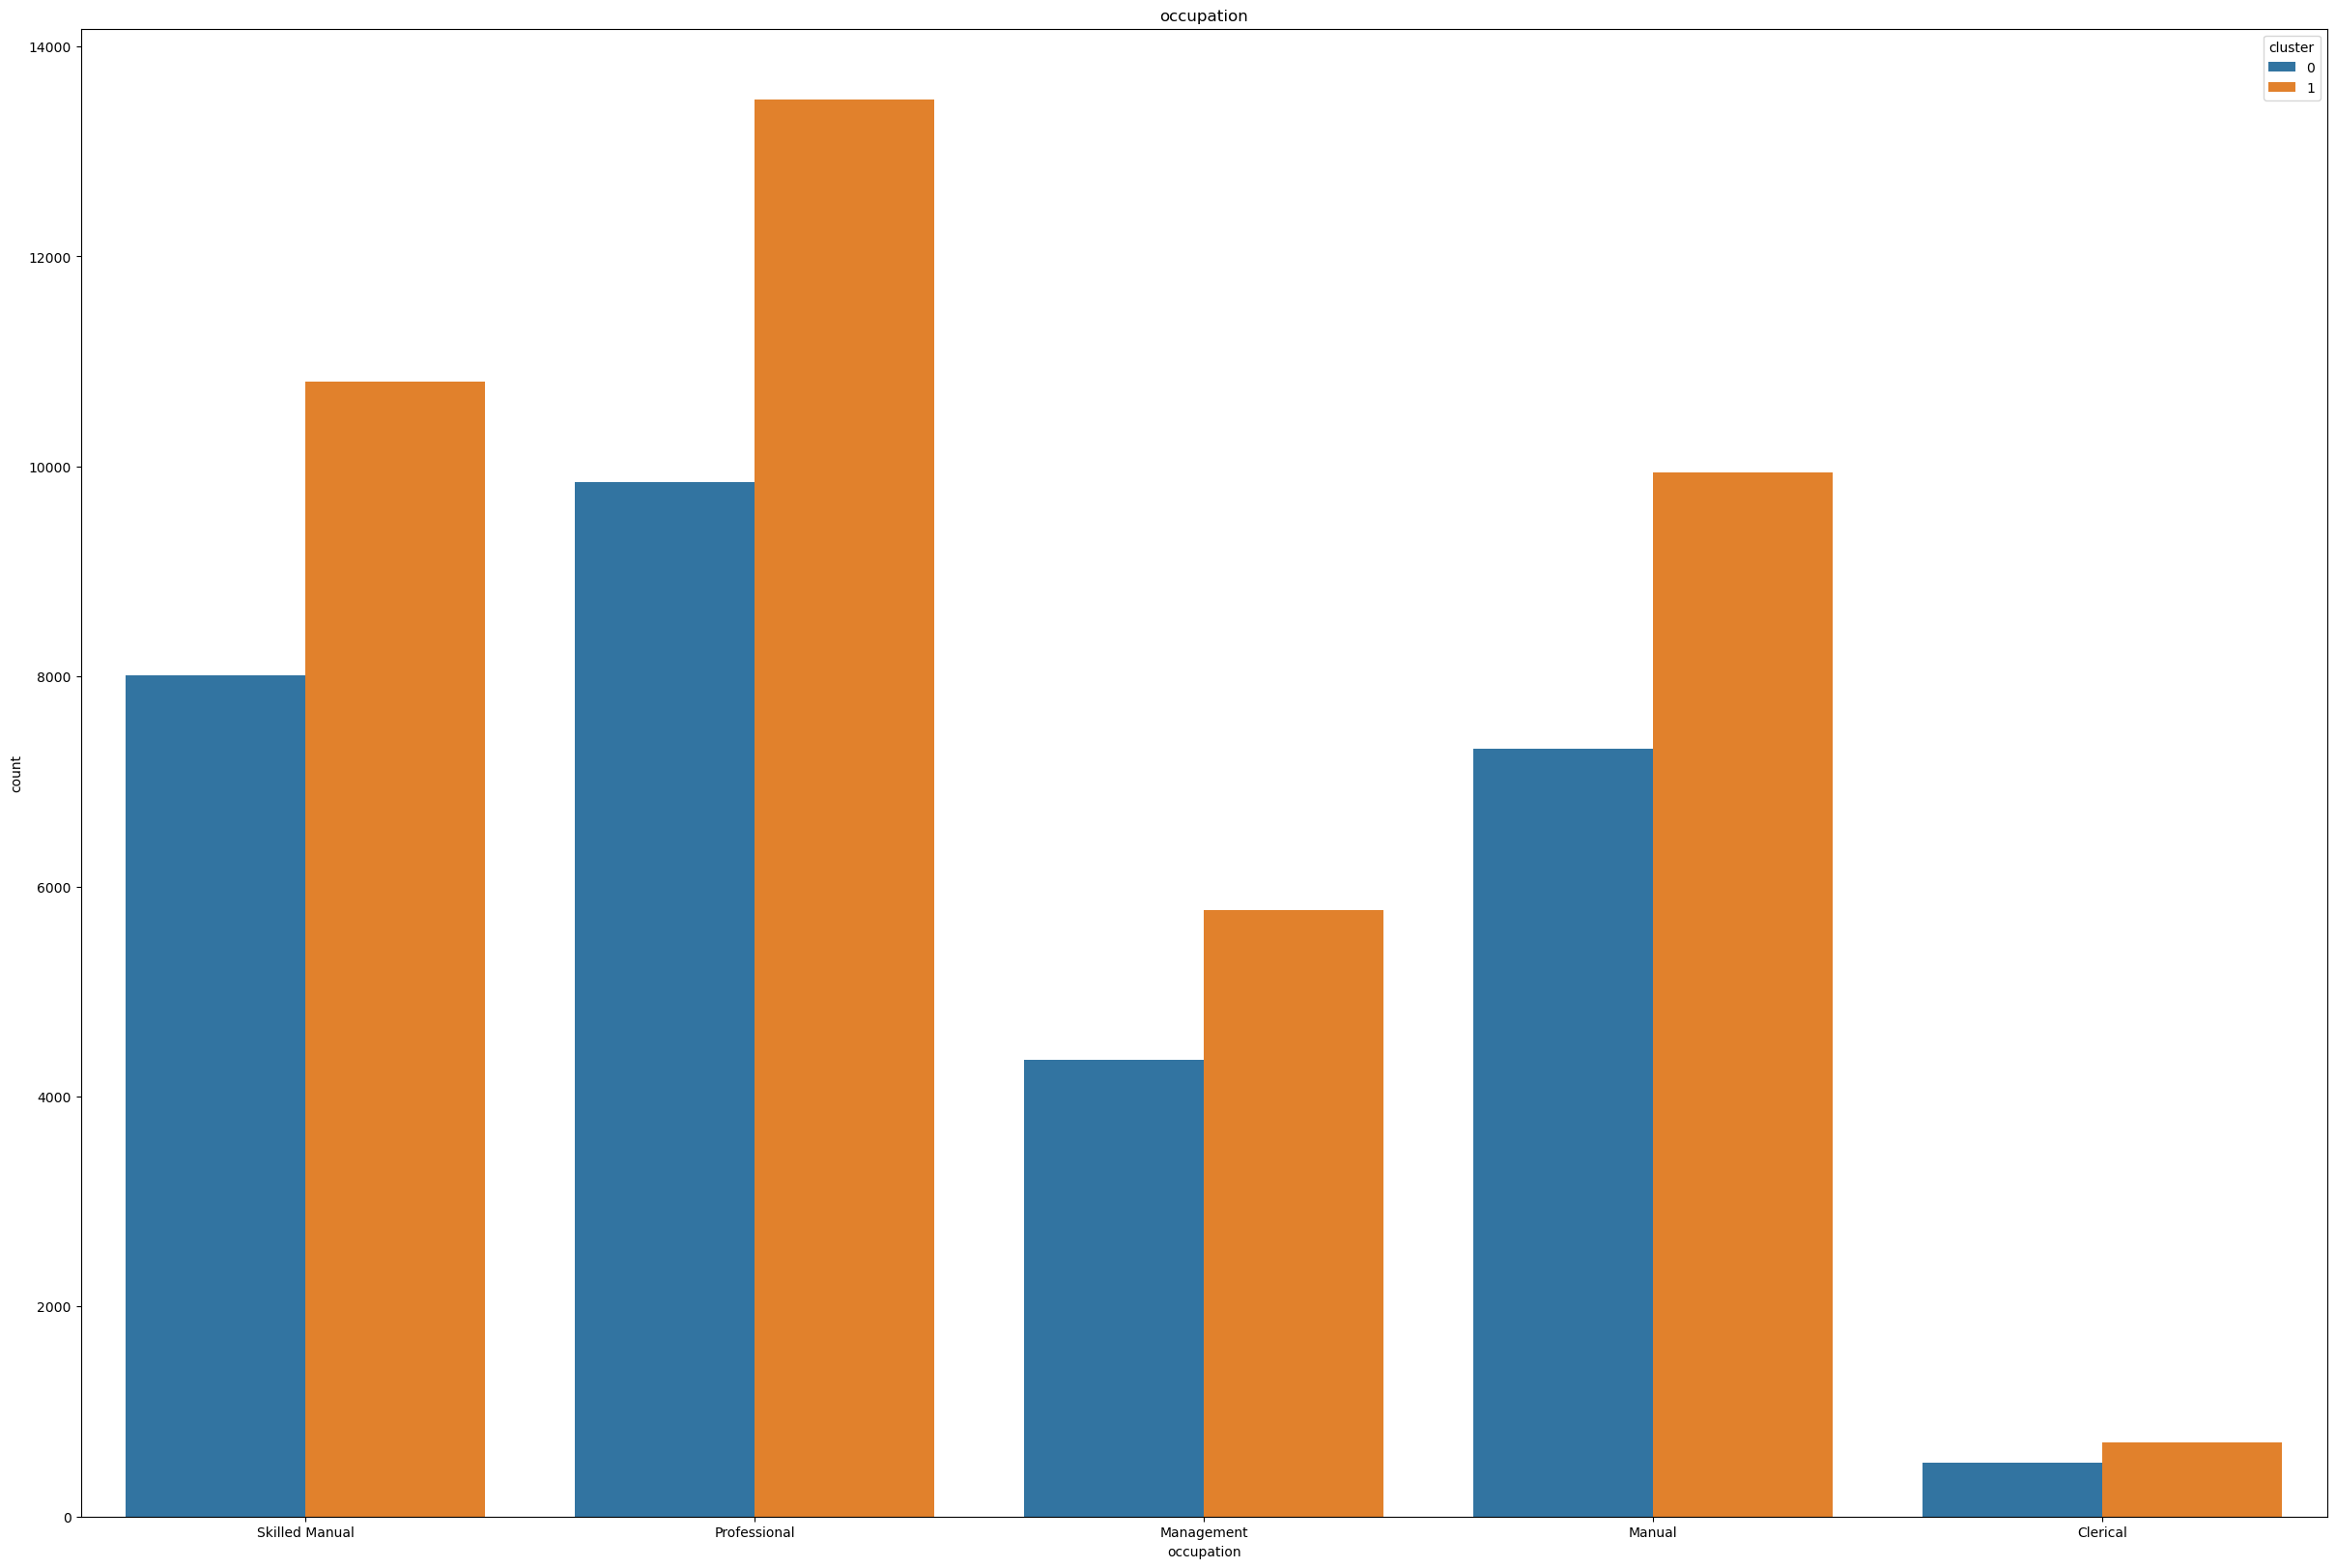

In [53]:
for i in df_cluster_cat.columns:
    plt.figure(figsize=(30,20))
    sns.countplot(x=df_cluster_cat[i],hue=df_cluster["cluster"])
    plt.title(i)
    plt.show()

In [ ]:
# cluster 0.
#  customers visit all departments less than customers for cluster 1 (highest- produce).
# customers are targeted by less amount of promotion techniques than cluster 1(highest 0 -price winners, 1 - two day sale). 
#  customers are targeted by less amount of media_channels than cluster 1(hjghest - daily paper and radio).
# customers visit less stores across all store districts as compared to cluster 1(highest-california).
# customers have lower number of customers across all types of annual income as compared to cluster 1(highest - $30K-$50 K.
# customers visit less stores (having no video_store and having video store) as compared to cluster 1(highest -no video store). 
#  customers have less number of all categories of customer card as compared to cluster 1(highest - bronze card).
# customers are in less number for all types of occupation as compared to cluster 1(highest - professional).

* cluster 0 - coustomer influenced by price winners promotion_type and on an average buy more than 3 units of product having avg SRP of  more than 3 USD and unit cost of more than 4 USD and net weight of product greater than 12 ounces. 
* definition - cluster 0- price discount searchers buying  costlier products and more number of products . 
* definitiom - cluster 1 - sale day searchers buying  cheaper products and less number of products.